# 08. AIMS Business Intelligence Analysis
**Role: The Analyst**

This notebook performs business intelligence analysis on validated Silver Layer data.

## Purpose
1. Load Silver Layer Star Schema tables (Fact and Dimensions)
2. Calculate executive KPIs and operational metrics
3. Perform multi-dimensional analysis (Route, Class, Organization)
4. Generate actionable business insights

## Prerequisites
- Execute Notebook 01 (Data Profiling) to generate validation results
- Execute Notebook 07 (DQ Matrix & Modeling) to create Silver Layer tables

## Output
- Executive dashboard metrics
- Asset distribution analysis
- Cross-dimensional insights
- Geospatial analysis (if coordinates available)

In [28]:
# --- CONFIGURATION ---
import os
import sys
from pathlib import Path
from dotenv import load_dotenv

# 1. Detect Environment
try:
    from notebookutils import mssparkutils
    IS_FABRIC = True
    print("Running in Microsoft Fabric")
except ImportError:
    IS_FABRIC = False
    print("Running Locally")

# 2. Define Paths based on Environment
if IS_FABRIC:
    # Fabric: Use Lakehouse Paths
    BASE_DIR = Path("/lakehouse/default/Files")
    
    # Try to load .env from Lakehouse Files root
    env_path = BASE_DIR / ".env"
    if env_path.exists():
        load_dotenv(dotenv_path=env_path)
        print(f"Loaded configuration from {env_path}")
    
    # Define Silver Layer Path
    SILVER_DIR = BASE_DIR / os.getenv("SILVER_PATH", "data/silver_layer")
    
else:
    # Local: Use project structure
    load_dotenv()
    
    # Determine project root
    project_root_local = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
    BASE_DIR = project_root_local
    
    # Define Silver Layer Path
    SILVER_DIR = BASE_DIR / os.getenv("SILVER_PATH", "data/silver_layer")

print(f"Configuration:")
print(f"   Environment: {'Fabric' if IS_FABRIC else 'Local'}")
print(f"   Silver Layer: {SILVER_DIR}")
print(f"   Directory Exists: {SILVER_DIR.exists()}")

Running Locally
Configuration:
   Environment: Local
   Silver Layer: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/data/silver_layer
   Directory Exists: True


In [29]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Visualization Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Data Loading: Silver Layer Tables

In [30]:
# Load Star Schema Tables
def load_silver_table(table_name):
    """
    Load a Silver Layer table from Parquet format.
    Returns None if table does not exist.
    """
    file_path = SILVER_DIR / f"{table_name}.parquet"
    if not file_path.exists():
        print(f"WARNING: {table_name} not found at {file_path}")
        return None
    
    try:
        df = pd.read_parquet(file_path, engine='pyarrow')
        print(f"LOADED: {table_name} ({len(df):,} rows, {len(df.columns)} columns)")
        return df
    except Exception as e:
        print(f"ERROR loading {table_name}: {e}")
        return None

# Load all tables
print("Loading Silver Layer Tables...\n")
fact_assets = load_silver_table("FACT_Asset_Inventory")
dim_route = load_silver_table("DIM_Route")
dim_class = load_silver_table("DIM_AssetClass")
dim_org = load_silver_table("DIM_Organisation")
dim_date = load_silver_table("DIM_Date")
dim_status = load_silver_table("DIM_Status")

print("\nData loading complete.")

Loading Silver Layer Tables...

LOADED: FACT_Asset_Inventory (100,057 rows, 15 columns)
LOADED: DIM_Route (33 rows, 3 columns)
LOADED: DIM_AssetClass (5,644 rows, 5 columns)
LOADED: DIM_Organisation (28 rows, 3 columns)
LOADED: DIM_Date (84,961 rows, 10 columns)
LOADED: DIM_Status (4 rows, 3 columns)

Data loading complete.


## 2. Data Quality Assessment

In [31]:
# Assess completeness and integrity of loaded tables
if fact_assets is not None:
    print("=" * 60)
    print("DATA QUALITY ASSESSMENT")
    print("=" * 60)
    
    # Fact table completeness
    total_assets = len(fact_assets)
    missing_routes = fact_assets['Route_Key'].isna().sum()
    missing_classes = fact_assets['Class_Key'].isna().sum()
    missing_owners = fact_assets['Owner_Key'].isna().sum()
    
    print(f"\nFACT Table Completeness:")
    print(f"  Total Assets: {total_assets:,}")
    print(f"  Route Coverage: {((total_assets - missing_routes) / total_assets * 100):.1f}%")
    print(f"  Class Coverage: {((total_assets - missing_classes) / total_assets * 100):.1f}%")
    print(f"  Owner Coverage: {((total_assets - missing_owners) / total_assets * 100):.1f}%")
    
    # Referential integrity checks
    integrity_issues = []
    
    if dim_route is not None:
        orphaned_routes = fact_assets[~fact_assets['Route_Key'].isna()]['Route_Key'].isin(dim_route['Route_Key']).sum()
        if orphaned_routes < (total_assets - missing_routes):
            integrity_issues.append(f"Route Key referential integrity: {orphaned_routes} valid references")
    
    if dim_class is not None:
        orphaned_classes = fact_assets[~fact_assets['Class_Key'].isna()]['Class_Key'].isin(dim_class['Class_Key']).sum()
        if orphaned_classes < (total_assets - missing_classes):
            integrity_issues.append(f"Class Key referential integrity: {orphaned_classes} valid references")
    
    if integrity_issues:
        print(f"\nReferential Integrity Findings:")
        for issue in integrity_issues:
            print(f"  - {issue}")
    else:
        print(f"\nReferential Integrity: PASSED")
    
    print("\n" + "=" * 60)

DATA QUALITY ASSESSMENT

FACT Table Completeness:
  Total Assets: 100,057
  Route Coverage: 76.2%
  Class Coverage: 76.2%
  Owner Coverage: 100.0%

Referential Integrity: PASSED



## 3. Executive KPIs and Metrics

In [32]:
# Calculate high-level KPIs for executive dashboard
if fact_assets is not None:
    print("=" * 60)
    print("EXECUTIVE KEY PERFORMANCE INDICATORS")
    print("=" * 60)
    
    # Asset Portfolio Size
    total_assets = len(fact_assets)
    print(f"\n1. ASSET PORTFOLIO")
    print(f"   Total Assets Under Management: {total_assets:,}")
    
    # Route Coverage
    if dim_route is not None:
        total_routes = len(dim_route)
        routes_with_assets = fact_assets['Route_Key'].nunique()
        route_coverage = (routes_with_assets / total_routes * 100) if total_routes > 0 else 0
        print(f"\n2. ROUTE COVERAGE")
        print(f"   Total Routes: {total_routes}")
        print(f"   Routes with Assets: {routes_with_assets}")
        print(f"   Coverage Rate: {route_coverage:.1f}%")
    
    # Asset Classification Diversity
    if dim_class is not None:
        unique_classes = fact_assets['Class_Key'].nunique()
        total_classes = len(dim_class)
        print(f"\n3. ASSET CLASSIFICATION")
        print(f"   Total Asset Classes Defined: {total_classes:,}")
        print(f"   Asset Classes in Use: {unique_classes:,}")
        print(f"   Utilization Rate: {(unique_classes/total_classes*100):.1f}%")
    
    # Organizational Distribution
    if dim_org is not None:
        unique_owners = fact_assets['Owner_Key'].nunique()
        total_orgs = len(dim_org)
        print(f"\n4. ORGANIZATIONAL RESPONSIBILITY")
        print(f"   Total Organizations: {total_orgs}")
        print(f"   Organizations with Asset Ownership: {unique_owners}")
        print(f"   Participation Rate: {(unique_owners/total_orgs*100):.1f}%")
    
    # Status Distribution
    if 'Asset_Status' in fact_assets.columns:
        status_dist = fact_assets['Asset_Status'].value_counts()
        print(f"\n5. ASSET STATUS DISTRIBUTION")
        for status, count in status_dist.items():
            pct = (count / total_assets * 100)
            print(f"   {status}: {count:,} ({pct:.1f}%)")
    
    print("\n" + "=" * 60)

EXECUTIVE KEY PERFORMANCE INDICATORS

1. ASSET PORTFOLIO
   Total Assets Under Management: 100,057

2. ROUTE COVERAGE
   Total Routes: 33
   Routes with Assets: 19
   Coverage Rate: 57.6%

3. ASSET CLASSIFICATION
   Total Asset Classes Defined: 5,644
   Asset Classes in Use: 272
   Utilization Rate: 4.8%

4. ORGANIZATIONAL RESPONSIBILITY
   Total Organizations: 28
   Organizations with Asset Ownership: 13
   Participation Rate: 46.4%

5. ASSET STATUS DISTRIBUTION
   Archived: 63,913 (63.9%)
   Published: 25,951 (25.9%)
   Client-shared: 9,875 (9.9%)
   Work in progress: 318 (0.3%)



## 4. Asset Distribution Analysis

ASSET DISTRIBUTION BY ROUTE



Top 10 Routes by Asset Count:



,Asset_Count,Unique_Classes
Route_Code,,
H2ML,64331,251
H2BS,4262,114
H2HC,2896,75
ESDB,2351,27
H2EL,1056,67
H2RW,542,15
H2NC,467,51
CAW,277,10
BOK4,34,7


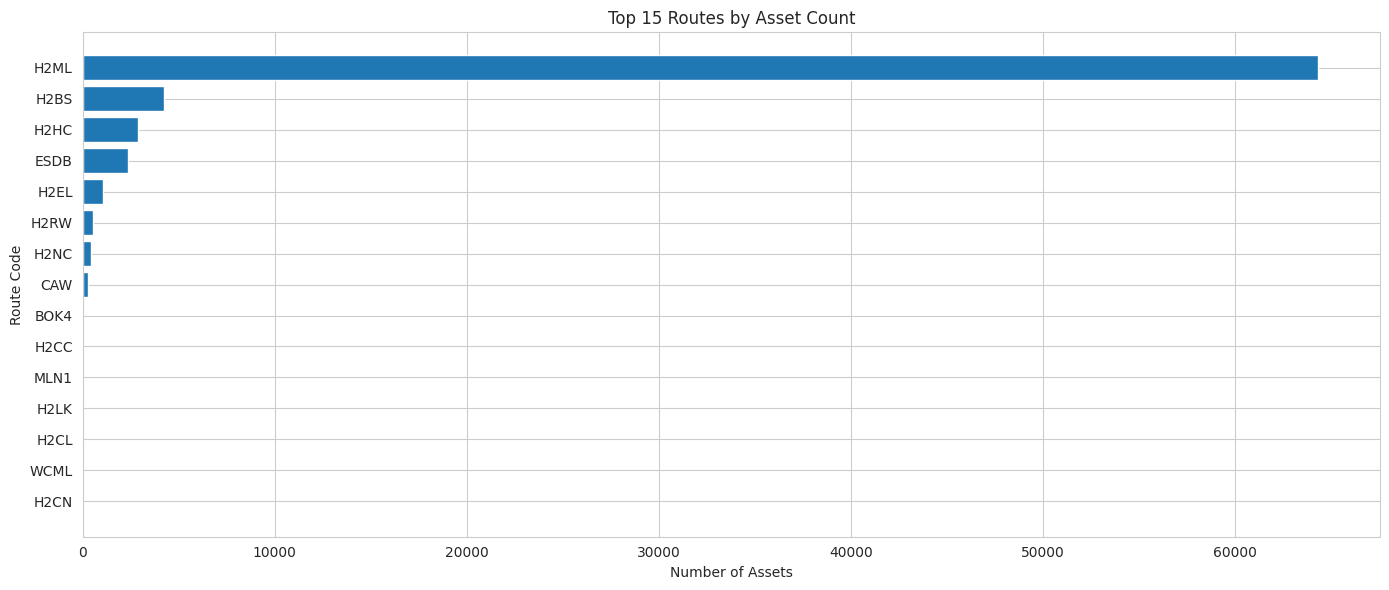

In [33]:
# Analyze asset distribution across routes
if fact_assets is not None and dim_route is not None:
    print("=" * 60)
    print("ASSET DISTRIBUTION BY ROUTE")
    print("=" * 60)
    
    # Join with dimension for readable names
    route_analysis = fact_assets.merge(
        dim_route[['Route_Key', 'Route_Code', 'Route_Description']],
        on='Route_Key',
        how='left'
    )
    
    # Calculate route statistics
    route_summary = route_analysis.groupby('Route_Code').agg({
        'Asset_Key': 'count',
        'Class_Key': 'nunique'
    }).rename(columns={
        'Asset_Key': 'Asset_Count',
        'Class_Key': 'Unique_Classes'
    }).sort_values('Asset_Count', ascending=False)
    
    print(f"\nTop 10 Routes by Asset Count:\n")
    display(route_summary.head(10))
    
    # Visualize distribution
    fig, ax = plt.subplots(figsize=(14, 6))
    top_routes = route_summary.head(15)
    ax.barh(top_routes.index, top_routes['Asset_Count'])
    ax.set_xlabel('Number of Assets')
    ax.set_ylabel('Route Code')
    ax.set_title('Top 15 Routes by Asset Count')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 60)

## 5. Asset Classification Analysis

ASSET CLASSIFICATION ANALYSIS

Top 15 Asset Classes by Count:

  Scoping Survey (ES-EC-SC): 8,447 (8.4%)
  Bat Building Emergence Survey - Dusk- Emergence survey of structures including buildings, bridges and caves (BS3) (ES-EC-BT-S3): 6,071 (6.1%)
  Bat - Tree Emergence Survey - Dusk and Dawn (BT3) (ES-EC-BT-T3): 5,796 (5.8%)
  Amphibian - Pond Survey (AA1 and AA2) (ES-EC-GC-A1): 5,772 (5.8%)
  Hazel dormouse - Nest tube survey (HD2) (ES-EC-HD-02): 4,188 (4.2%)
  Bat - Initial assessment of trees (ground level) (BT1) (ES-EC-BT-T1): 3,972 (4.0%)
  Bat - Tree Climbing Inspection (BT2) (ES-EC-BT-T2): 3,033 (3.0%)
  Reptiles - Survey (RE2) (ES-EC-RP-DS): 2,077 (2.1%)
  WS - Windowless sampling (EI-70-05-20): 1,898 (1.9%)
  Bat - Activity (transect) (BA1) (ES-EC-BT-A1): 1,789 (1.8%)
  Bat Building External - Initial assessment of structures including buildings, bridges and caves (BS1) (ES-EC-BT-S1): 1,552 (1.6%)
  CR - Cable percussion borehole with rotary cored follow on (EI-70-05-04): 1,

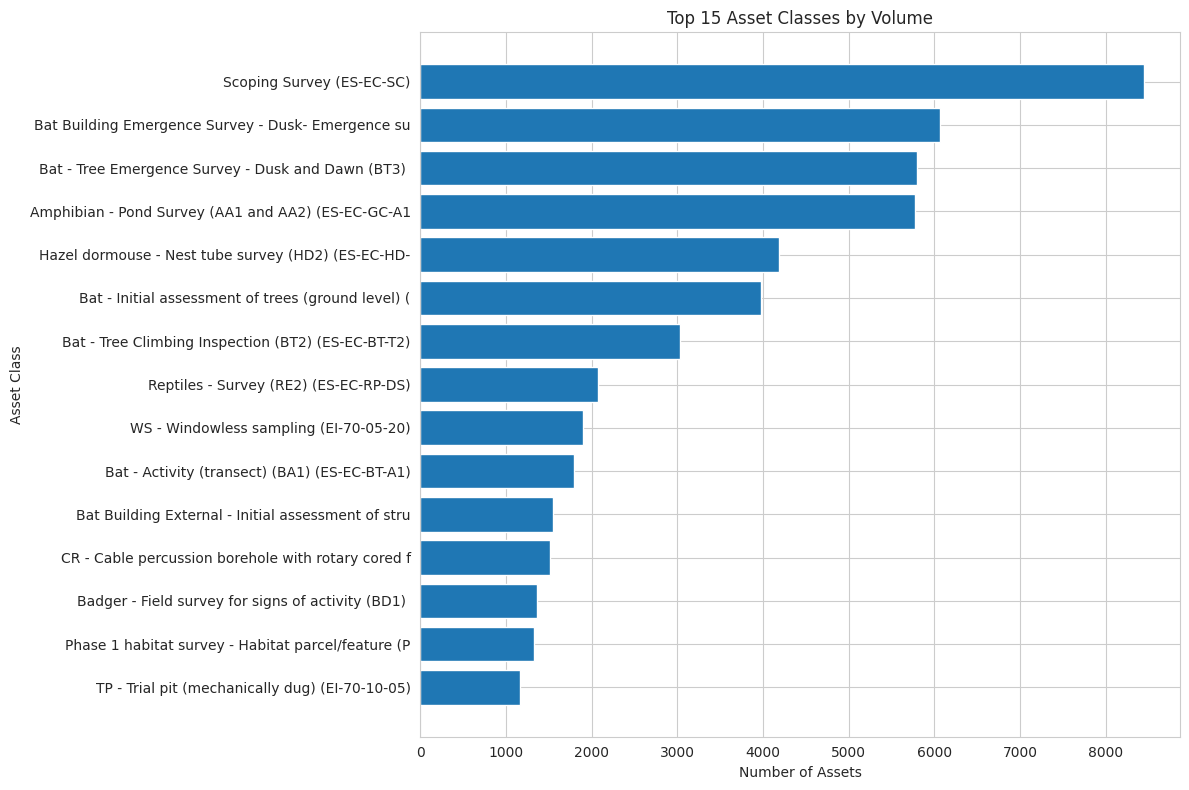

In [34]:
# Analyze asset distribution by classification
if fact_assets is not None and dim_class is not None:
    print("=" * 60)
    print("ASSET CLASSIFICATION ANALYSIS")
    print("=" * 60)
    
    # Use Class_Name directly from fact table (already has enriched data)
    # Top asset classes
    class_summary = fact_assets['Class_Name'].value_counts()
    
    print(f"\nTop 15 Asset Classes by Count:\n")
    top_classes = class_summary.head(15)
    for class_name, count in top_classes.items():
        if pd.notna(class_name):
            pct = (count / len(fact_assets) * 100)
            print(f"  {class_name}: {count:,} ({pct:.1f}%)")
    
    # Visualize (exclude NaN values)
    top_classes_clean = top_classes[top_classes.index.notna()]
    if len(top_classes_clean) > 0:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.barh(range(len(top_classes_clean)), top_classes_clean.values)
        ax.set_yticks(range(len(top_classes_clean)))
        ax.set_yticklabels([str(name)[:50] for name in top_classes_clean.index])
        ax.set_xlabel('Number of Assets')
        ax.set_ylabel('Asset Class')
        ax.set_title('Top 15 Asset Classes by Volume')
        ax.invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    print("\n" + "=" * 60)

## 6. Organizational Asset Ownership

ORGANIZATIONAL ASSET OWNERSHIP ANALYSIS

Top 10 Organizations by Asset Count:


Top 10 Organizations by Asset Count:



,Total_Assets,Asset_Classes,Routes_Covered
Organisation_Name,,,
HS2,93399,249,18
BBV Joint Venture,3371,81,5
EK Joint Venture,2477,72,3
Phase 2a,415,23,3
SCS Joint Venture,169,23,1
TPY,131,14,4
Align Joint Venture,42,13,1
BBVS Joint venture - Stations,33,14,1
Costain Skanska Joint Venture,5,3,1


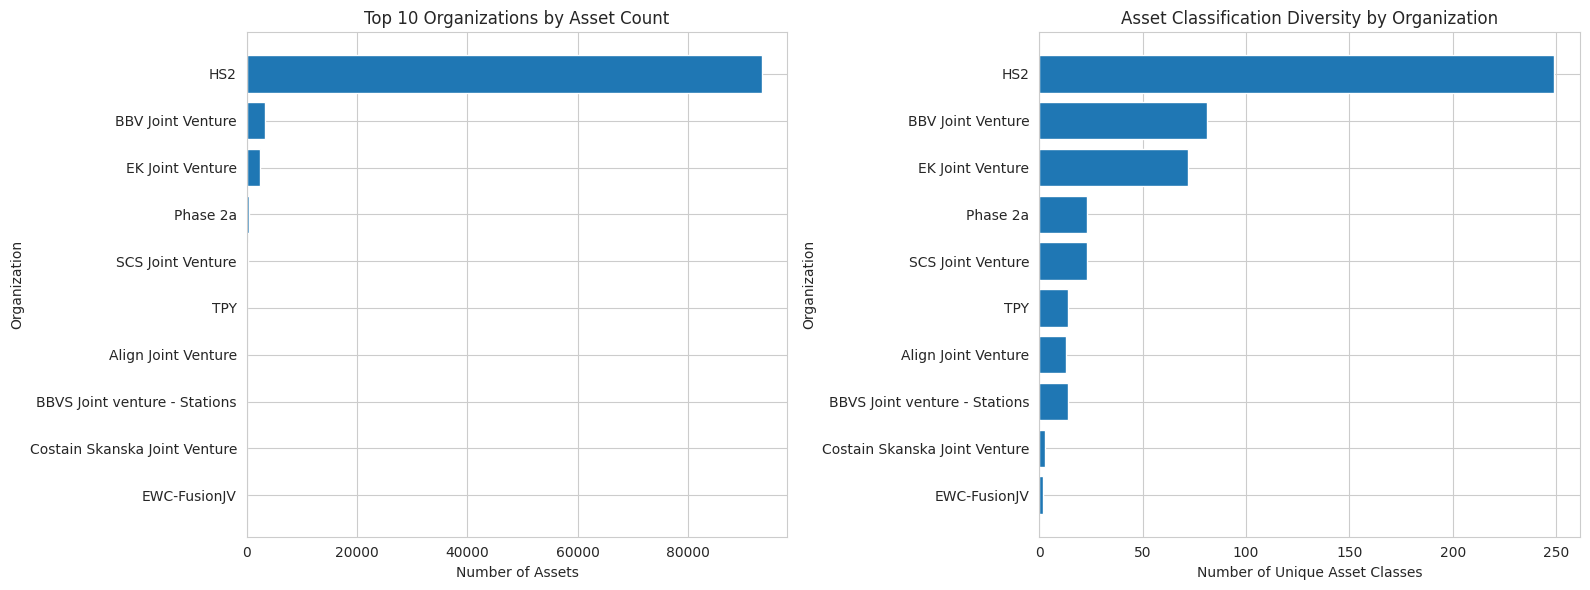

In [35]:
# Analyze asset ownership by organization
if fact_assets is not None and dim_org is not None:
    print("=" * 60)
    print("ORGANIZATIONAL ASSET OWNERSHIP ANALYSIS")
    print("=" * 60)
    
    # Use Owner_Key directly from fact table (contains organization names)
    # Calculate ownership statistics
    org_summary = fact_assets.groupby('Owner_Key').agg({
        'Asset_Key': 'count',
        'Class_Key': 'nunique',
        'Route_Key': 'nunique'
    }).rename(columns={
        'Asset_Key': 'Total_Assets',
        'Class_Key': 'Asset_Classes',
        'Route_Key': 'Routes_Covered'
    }).sort_values('Total_Assets', ascending=False)
    
    org_summary.index.name = 'Organisation_Name'
    
    print(f"\nTop 10 Organizations by Asset Count:\n")
    display(org_summary.head(10))
    
    # Visualize ownership distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Asset count distribution
    top_orgs = org_summary.head(10)
    ax1.barh(range(len(top_orgs)), top_orgs['Total_Assets'])
    ax1.set_yticks(range(len(top_orgs)))
    ax1.set_yticklabels([name[:30] for name in top_orgs.index])
    ax1.set_xlabel('Number of Assets')
    ax1.set_ylabel('Organization')
    ax1.set_title('Top 10 Organizations by Asset Count')
    ax1.invert_yaxis()
    
    # Asset class diversity
    ax2.barh(range(len(top_orgs)), top_orgs['Asset_Classes'])
    ax2.set_yticks(range(len(top_orgs)))
    ax2.set_yticklabels([name[:30] for name in top_orgs.index])
    ax2.set_xlabel('Number of Unique Asset Classes')
    ax2.set_ylabel('Organization')
    ax2.set_title('Asset Classification Diversity by Organization')
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 60)

## 7. Cross-Dimensional Analysis

CROSS-DIMENSIONAL ANALYSIS: ROUTE x ASSET CLASS

Asset Distribution Heatmap (Top 10 Routes x Top 10 Classes):



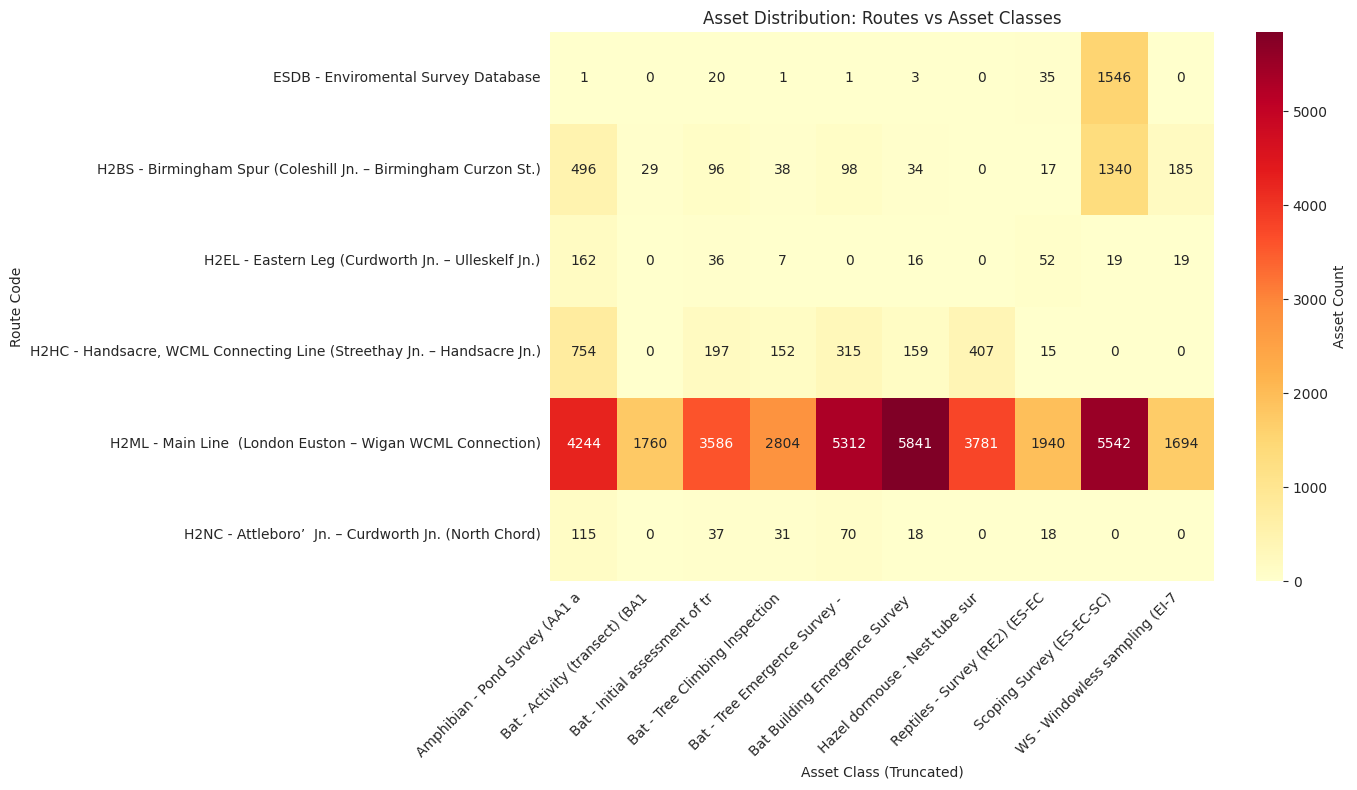

In [36]:
# Perform cross-dimensional analysis: Route x Asset Class
if fact_assets is not None and dim_route is not None and dim_class is not None:
    print("=" * 60)
    print("CROSS-DIMENSIONAL ANALYSIS: ROUTE x ASSET CLASS")
    print("=" * 60)
    
    # Use fact_assets directly (already has Route_Name and Class_Name)
    # Get top routes and classes
    top_routes = fact_assets['Route_Name'].value_counts().head(10).index
    top_classes = fact_assets['Class_Name'].value_counts().head(10).index
    
    # Filter dataset
    filtered = fact_assets[
        fact_assets['Route_Name'].isin(top_routes) & 
        fact_assets['Class_Name'].isin(top_classes)
    ]
    
    # Create pivot table
    pivot = pd.crosstab(
        filtered['Route_Name'],
        filtered['Class_Name'].str[:30]  # Truncate for display
    )
    
    print(f"\nAsset Distribution Heatmap (Top 10 Routes x Top 10 Classes):\n")
    
    # Visualize as heatmap
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.heatmap(pivot, annot=True, fmt='d', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Asset Count'})
    ax.set_title('Asset Distribution: Routes vs Asset Classes')
    ax.set_xlabel('Asset Class (Truncated)')
    ax.set_ylabel('Route Code')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 60)

## 8. Geospatial Analysis (If Available)

GEOSPATIAL DISTRIBUTION ANALYSIS

Geospatial Coverage: 72,987 assets (72.9%)
Valid UK coordinates: 57,040 assets

Coordinate Ranges:
  Easting: 20588 to 608857
  Northing: 13005 to 489641

Spatial Distribution Statistics:
  Easting Mean: 453120
  Northing Mean: 250529
  Easting Std Dev: 39601
  Northing Std Dev: 45640

Spatial Distribution by Route:


,OSGBEASTING_mean,OSGBEASTING_std,OSGBEASTING_count,OSGBNORTHING_mean,OSGBNORTHING_std
Route_Name,,,,,
H2ML - Main Line (London Euston – Wigan WCML Connection),458734.0,38202.0,50302,243901.0,44231.0
H2BS - Birmingham Spur (Coleshill Jn. – Birmingham Curzon St.),410501.0,28224.0,3064,288364.0,12725.0
"H2HC - Handsacre, WCML Connecting Line (Streethay Jn. – Handsacre Jn.)",409251.0,5089.0,2728,315414.0,4318.0
H2EL - Eastern Leg (Curdworth Jn. – Ulleskelf Jn.),420070.0,4076.0,543,294435.0,1831.0
H2NC - Attleboro’ Jn. – Curdworth Jn. (North Chord),418446.0,553.0,393,291017.0,675.0
"H2CC - Crewe, WCML Connecting Line",373244.0,310.0,4,348576.0,692.0
WCML - NR: West Coast Mainline,372301.0,468.0,4,351051.0,1270.0
ESDB - Enviromental Survey Database,491471.0,18778.0,2,200494.0,20557.0


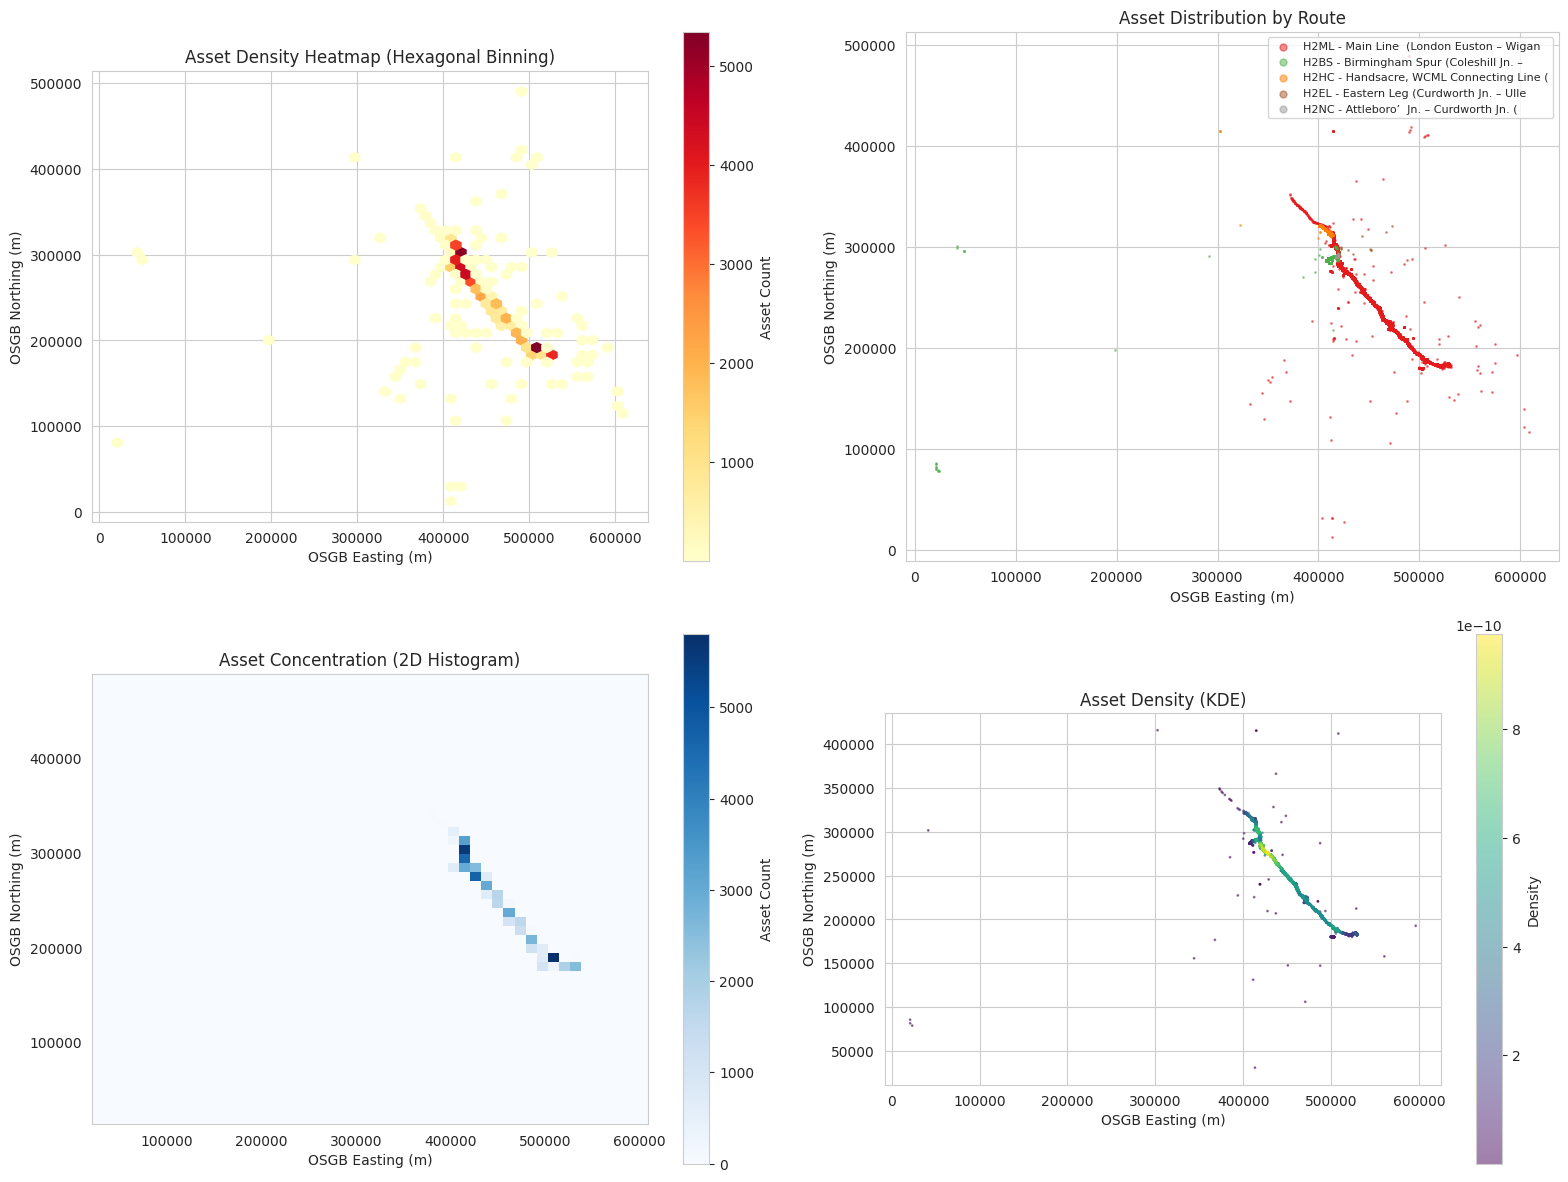


Spatial Clustering Analysis:
  Easting Quartiles: Q1=419002, Q2=438702, Q3=489316
  Northing Quartiles: Q1=203700, Q2=262614, Q3=289731

Spatial Extent:
  East-West span: 588.3 km
  North-South span: 476.6 km
  Approximate coverage area: 280390.2 km²



In [37]:
# Analyze geospatial distribution if coordinates available
if fact_assets is not None and 'OSGBEASTING' in fact_assets.columns and 'OSGBNORTHING' in fact_assets.columns:
    print("=" * 60)
    print("GEOSPATIAL DISTRIBUTION ANALYSIS")
    print("=" * 60)
    
    # Filter assets with valid coordinates
    geo_assets = fact_assets[
        fact_assets['OSGBEASTING'].notna() & 
        fact_assets['OSGBNORTHING'].notna()
    ].copy()
    
    geo_coverage = (len(geo_assets) / len(fact_assets) * 100)
    print(f"\nGeospatial Coverage: {len(geo_assets):,} assets ({geo_coverage:.1f}%)")
    
    if len(geo_assets) > 0:
        # Convert coordinates to numeric and filter valid OSGB coordinates
        geo_assets['OSGBEASTING'] = pd.to_numeric(geo_assets['OSGBEASTING'], errors='coerce')
        geo_assets['OSGBNORTHING'] = pd.to_numeric(geo_assets['OSGBNORTHING'], errors='coerce')
        
        # Filter to valid OSGB range (UK coordinates: Easting 0-700000, Northing 0-1300000)
        geo_assets = geo_assets[
            (geo_assets['OSGBEASTING'] > 0) & (geo_assets['OSGBEASTING'] < 700000) &
            (geo_assets['OSGBNORTHING'] > 0) & (geo_assets['OSGBNORTHING'] < 1300000)
        ]
        
        print(f"Valid UK coordinates: {len(geo_assets):,} assets")
        print(f"\nCoordinate Ranges:")
        print(f"  Easting: {geo_assets['OSGBEASTING'].min():.0f} to {geo_assets['OSGBEASTING'].max():.0f}")
        print(f"  Northing: {geo_assets['OSGBNORTHING'].min():.0f} to {geo_assets['OSGBNORTHING'].max():.0f}")
        
        # Statistical analysis
        print(f"\nSpatial Distribution Statistics:")
        print(f"  Easting Mean: {geo_assets['OSGBEASTING'].mean():.0f}")
        print(f"  Northing Mean: {geo_assets['OSGBNORTHING'].mean():.0f}")
        print(f"  Easting Std Dev: {geo_assets['OSGBEASTING'].std():.0f}")
        print(f"  Northing Std Dev: {geo_assets['OSGBNORTHING'].std():.0f}")
        
        # Route-based spatial analysis
        if 'Route_Name' in geo_assets.columns:
            print(f"\nSpatial Distribution by Route:")
            route_spatial = geo_assets.groupby('Route_Name').agg({
                'OSGBEASTING': ['mean', 'std', 'count'],
                'OSGBNORTHING': ['mean', 'std']
            }).round(0)
            route_spatial.columns = ['_'.join(col).strip() for col in route_spatial.columns.values]
            route_spatial = route_spatial.sort_values('OSGBEASTING_count', ascending=False)
            display(route_spatial.head(10))
        
        # Create multi-panel visualization
        fig = plt.figure(figsize=(16, 12))
        
        # 1. Hex bin density map
        ax1 = plt.subplot(2, 2, 1)
        hexbin = ax1.hexbin(
            geo_assets['OSGBEASTING'], 
            geo_assets['OSGBNORTHING'],
            gridsize=50,
            cmap='YlOrRd',
            mincnt=1
        )
        ax1.set_xlabel('OSGB Easting (m)')
        ax1.set_ylabel('OSGB Northing (m)')
        ax1.set_title('Asset Density Heatmap (Hexagonal Binning)')
        plt.colorbar(hexbin, ax=ax1, label='Asset Count')
        ax1.set_aspect('equal')
        
        # 2. Scatter plot by route (top routes only)
        ax2 = plt.subplot(2, 2, 2)
        if 'Route_Name' in geo_assets.columns:
            top_routes = geo_assets['Route_Name'].value_counts().head(5).index
            colors = plt.cm.Set1(np.linspace(0, 1, len(top_routes)))
            for idx, route in enumerate(top_routes):
                route_data = geo_assets[geo_assets['Route_Name'] == route]
                ax2.scatter(
                    route_data['OSGBEASTING'],
                    route_data['OSGBNORTHING'],
                    alpha=0.5,
                    s=1,
                    c=[colors[idx]],
                    label=route[:40]
                )
            ax2.legend(markerscale=5, loc='upper right', fontsize=8)
        else:
            ax2.scatter(
                geo_assets['OSGBEASTING'],
                geo_assets['OSGBNORTHING'],
                alpha=0.3,
                s=1
            )
        ax2.set_xlabel('OSGB Easting (m)')
        ax2.set_ylabel('OSGB Northing (m)')
        ax2.set_title('Asset Distribution by Route')
        ax2.set_aspect('equal')
        
        # 3. 2D Histogram
        ax3 = plt.subplot(2, 2, 3)
        hist = ax3.hist2d(
            geo_assets['OSGBEASTING'],
            geo_assets['OSGBNORTHING'],
            bins=50,
            cmap='Blues'
        )
        ax3.set_xlabel('OSGB Easting (m)')
        ax3.set_ylabel('OSGB Northing (m)')
        ax3.set_title('Asset Concentration (2D Histogram)')
        plt.colorbar(hist[3], ax=ax3, label='Asset Count')
        ax3.set_aspect('equal')
        
        # 4. KDE Contour plot
        ax4 = plt.subplot(2, 2, 4)
        try:
            from scipy.stats import gaussian_kde
            # Sample for performance if dataset is large
            sample_size = min(10000, len(geo_assets))
            sample = geo_assets.sample(sample_size, random_state=42)
            
            x = sample['OSGBEASTING'].values
            y = sample['OSGBNORTHING'].values
            
            # Calculate point density
            xy = np.vstack([x, y])
            z = gaussian_kde(xy)(xy)
            
            scatter = ax4.scatter(x, y, c=z, s=1, cmap='viridis', alpha=0.5)
            ax4.set_xlabel('OSGB Easting (m)')
            ax4.set_ylabel('OSGB Northing (m)')
            ax4.set_title('Asset Density (KDE)')
            plt.colorbar(scatter, ax=ax4, label='Density')
            ax4.set_aspect('equal')
        except ImportError:
            ax4.text(0.5, 0.5, 'KDE plot requires scipy', 
                    ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Asset Density (KDE) - scipy not available')
        
        plt.tight_layout()
        plt.show()
        
        # Spatial clustering insights
        print(f"\nSpatial Clustering Analysis:")
        easting_quartiles = geo_assets['OSGBEASTING'].quantile([0.25, 0.5, 0.75])
        northing_quartiles = geo_assets['OSGBNORTHING'].quantile([0.25, 0.5, 0.75])
        
        print(f"  Easting Quartiles: Q1={easting_quartiles[0.25]:.0f}, "
              f"Q2={easting_quartiles[0.5]:.0f}, Q3={easting_quartiles[0.75]:.0f}")
        print(f"  Northing Quartiles: Q1={northing_quartiles[0.25]:.0f}, "
              f"Q2={northing_quartiles[0.5]:.0f}, Q3={northing_quartiles[0.75]:.0f}")
        
        # Calculate spatial extent
        easting_range = geo_assets['OSGBEASTING'].max() - geo_assets['OSGBEASTING'].min()
        northing_range = geo_assets['OSGBNORTHING'].max() - geo_assets['OSGBNORTHING'].min()
        print(f"\nSpatial Extent:")
        print(f"  East-West span: {easting_range/1000:.1f} km")
        print(f"  North-South span: {northing_range/1000:.1f} km")
        print(f"  Approximate coverage area: {(easting_range * northing_range)/(1000000):.1f} km²")
    
    print("\n" + "=" * 60)
else:
    print("Geospatial analysis not available: Coordinate columns not found.")

## 9. Asset Portfolio Diversity Analysis

PORTFOLIO DIVERSITY ANALYSIS

DIVERSITY METRICS:
  Unique Routes: 19
  Unique Asset Classes: 272
  Unique Owners: 13

AVERAGE DISTRIBUTION:
  Assets per Route: 5266
  Assets per Class: 368
  Assets per Owner: 7697

CONCENTRATION INDEX (HHI):
  Route Concentration: 0.4168 (High)
  Class Concentration: 0.0249 (Low)
  Owner Concentration: 0.8731 (High)

TOP 3 CONTRIBUTORS BY DIMENSION:

  Routes:
    H2ML - Main Line  (London Euston – Wigan WCML Conn: 64.3%
    H2BS - Birmingham Spur (Coleshill Jn. – Birmingham: 4.3%
    H2HC - Handsacre, WCML Connecting Line (Streethay : 2.9%

  Asset Classes:
    Scoping Survey (ES-EC-SC): 8.4%
    Bat Building Emergence Survey - Dusk- Emergence su: 6.1%
    Bat - Tree Emergence Survey - Dusk and Dawn (BT3) : 5.8%

  Owners:
    HS2: 93.3%
    BBV Joint Venture: 3.4%
    EK Joint Venture: 2.5%


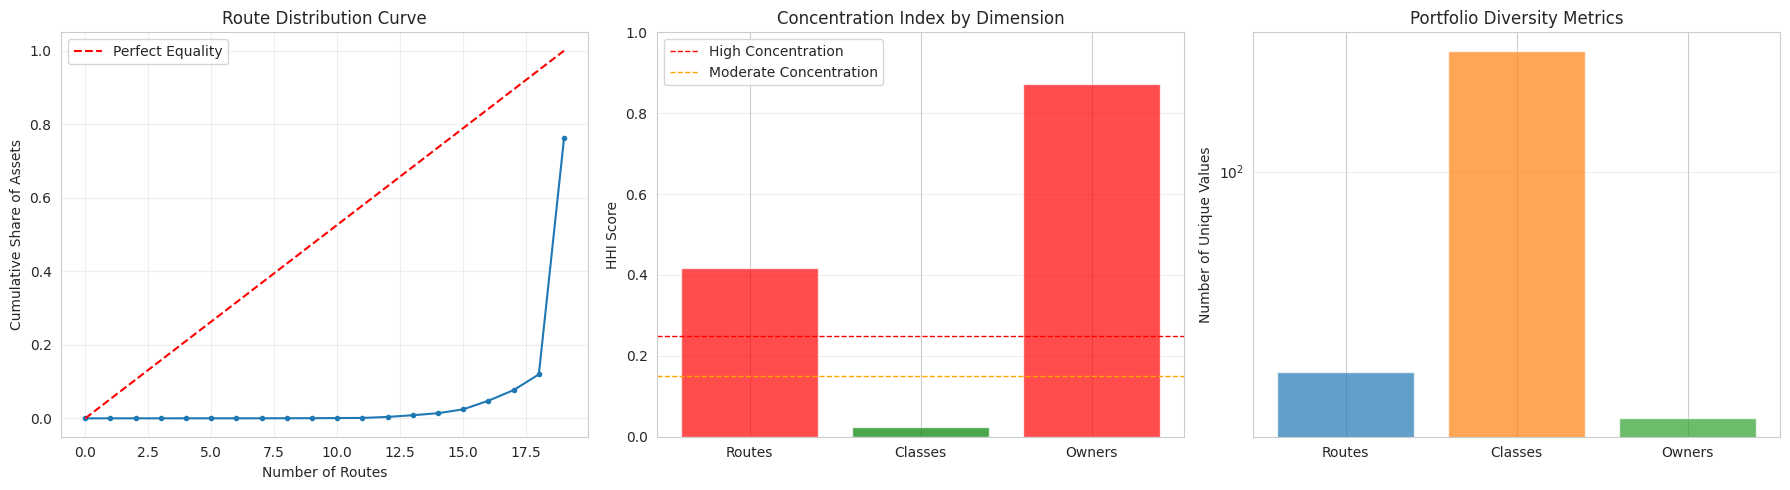


RISK ASSESSMENT:
  [WARNING] High route concentration detected - portfolio exposed to single route risks
  [WARNING] Extreme owner concentration - organizational dependency risk
  [NOTE] High class diversity - may indicate complex portfolio management requirements



In [38]:
# Analyze portfolio diversity across multiple dimensions
if fact_assets is not None:
    print("=" * 60)
    print("PORTFOLIO DIVERSITY ANALYSIS")
    print("=" * 60)
    
    # Calculate diversity metrics
    total_assets = len(fact_assets)
    
    # Route diversity
    route_diversity = fact_assets['Route_Key'].nunique()
    assets_per_route = total_assets / route_diversity if route_diversity > 0 else 0
    
    # Class diversity
    class_diversity = fact_assets['Class_Key'].nunique()
    assets_per_class = total_assets / class_diversity if class_diversity > 0 else 0
    
    # Owner diversity
    owner_diversity = fact_assets['Owner_Key'].nunique()
    assets_per_owner = total_assets / owner_diversity if owner_diversity > 0 else 0
    
    # Calculate Herfindahl-Hirschman Index (HHI) for concentration
    # HHI closer to 1 = high concentration, closer to 0 = high diversity
    
    # Route concentration
    route_shares = fact_assets['Route_Key'].value_counts() / total_assets
    hhi_route = (route_shares ** 2).sum()
    
    # Class concentration
    class_shares = fact_assets['Class_Key'].value_counts() / total_assets
    hhi_class = (class_shares ** 2).sum()
    
    # Owner concentration
    owner_shares = fact_assets['Owner_Key'].value_counts() / total_assets
    hhi_owner = (owner_shares ** 2).sum()
    
    print(f"\nDIVERSITY METRICS:")
    print(f"  Unique Routes: {route_diversity}")
    print(f"  Unique Asset Classes: {class_diversity}")
    print(f"  Unique Owners: {owner_diversity}")
    
    print(f"\nAVERAGE DISTRIBUTION:")
    print(f"  Assets per Route: {assets_per_route:.0f}")
    print(f"  Assets per Class: {assets_per_class:.0f}")
    print(f"  Assets per Owner: {assets_per_owner:.0f}")
    
    print(f"\nCONCENTRATION INDEX (HHI):")
    print(f"  Route Concentration: {hhi_route:.4f} ({'High' if hhi_route > 0.25 else 'Moderate' if hhi_route > 0.15 else 'Low'})")
    print(f"  Class Concentration: {hhi_class:.4f} ({'High' if hhi_class > 0.25 else 'Moderate' if hhi_class > 0.15 else 'Low'})")
    print(f"  Owner Concentration: {hhi_owner:.4f} ({'High' if hhi_owner > 0.25 else 'Moderate' if hhi_owner > 0.15 else 'Low'})")
    
    # Top contributors analysis
    print(f"\nTOP 3 CONTRIBUTORS BY DIMENSION:")
    
    # Top routes
    top_routes_share = route_shares.head(3)
    print(f"\n  Routes:")
    for route, share in top_routes_share.items():
        if pd.notna(route):
            route_name = fact_assets[fact_assets['Route_Key'] == route]['Route_Name'].iloc[0] if len(fact_assets[fact_assets['Route_Key'] == route]) > 0 else route
            print(f"    {route_name[:50]}: {share*100:.1f}%")
    
    # Top classes
    top_classes_share = class_shares.head(3)
    print(f"\n  Asset Classes:")
    for cls, share in top_classes_share.items():
        if pd.notna(cls):
            cls_name = fact_assets[fact_assets['Class_Key'] == cls]['Class_Name'].iloc[0] if len(fact_assets[fact_assets['Class_Key'] == cls]) > 0 else cls
            print(f"    {cls_name[:50]}: {share*100:.1f}%")
    
    # Top owners
    top_owners_share = owner_shares.head(3)
    print(f"\n  Owners:")
    for owner, share in top_owners_share.items():
        if pd.notna(owner):
            print(f"    {owner}: {share*100:.1f}%")
    
    # Visualize diversity
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Lorenz curve for route distribution
    ax1 = axes[0]
    route_cumsum = route_shares.sort_values().cumsum()
    ax1.plot([0] + list(range(1, len(route_cumsum)+1)), [0] + list(route_cumsum), marker='o', markersize=3)
    ax1.plot([0, len(route_cumsum)], [0, 1], 'r--', label='Perfect Equality')
    ax1.set_xlabel('Number of Routes')
    ax1.set_ylabel('Cumulative Share of Assets')
    ax1.set_title('Route Distribution Curve')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Concentration by dimension
    ax2 = axes[1]
    dimensions = ['Routes', 'Classes', 'Owners']
    hhi_values = [hhi_route, hhi_class, hhi_owner]
    colors_hhi = ['red' if h > 0.25 else 'orange' if h > 0.15 else 'green' for h in hhi_values]
    bars = ax2.bar(dimensions, hhi_values, color=colors_hhi, alpha=0.7)
    ax2.axhline(y=0.25, color='red', linestyle='--', linewidth=1, label='High Concentration')
    ax2.axhline(y=0.15, color='orange', linestyle='--', linewidth=1, label='Moderate Concentration')
    ax2.set_ylabel('HHI Score')
    ax2.set_title('Concentration Index by Dimension')
    ax2.set_ylim(0, 1)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Portfolio balance
    ax3 = axes[2]
    diversity_metrics = [route_diversity, class_diversity, owner_diversity]
    ax3.bar(dimensions, diversity_metrics, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
    ax3.set_ylabel('Number of Unique Values')
    ax3.set_title('Portfolio Diversity Metrics')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Risk assessment
    print(f"\nRISK ASSESSMENT:")
    if hhi_route > 0.4:
        print("  [WARNING] High route concentration detected - portfolio exposed to single route risks")
    if hhi_owner > 0.8:
        print("  [WARNING] Extreme owner concentration - organizational dependency risk")
    if hhi_class < 0.05:
        print("  [NOTE] High class diversity - may indicate complex portfolio management requirements")
    
    print("\n" + "=" * 60)

## 10. Data Completeness and Quality Scoring

DATA COMPLETENESS AND QUALITY SCORING

CRITICAL FIELDS COMPLETENESS:
  ✓ Asset_Key: 100.0% (100,057/100,057)
  ✗ Route_Key: 76.2% (76,291/100,057)
  ✗ Class_Key: 76.2% (76,291/100,057)
  ✓ Owner_Key: 100.0% (100,057/100,057)
  ✓ Asset_Status: 100.0% (100,057/100,057)

IMPORTANT FIELDS COMPLETENESS:
  ✓ Asset_Name: 100.0% (100,057/100,057)
  ⚠ Class_Name: 76.2% (76,291/100,057)
  ⚠ Route_Name: 76.2% (76,291/100,057)

OPTIONAL FIELDS COMPLETENESS:
  ✓ OSGBEASTING: 72.9% (72,987/100,057)
  ✓ OSGBNORTHING: 72.9% (72,987/100,057)
  ✓ Chainage_Baseline: 76.2% (76,291/100,057)
  ✓ PHASEID: 100.0% (100,057/100,057)

COMPOSITE QUALITY SCORES:
  Critical Fields Average: 90.5%
  Important Fields Average: 84.2%
  Optional Fields Average: 80.5%

  OVERALL QUALITY SCORE: 86.6/100
  Quality Grade: B+ (Good)

RECORD-LEVEL ANALYSIS:
  Complete Records (all critical fields): 76,291 (76.2%)
  Incomplete Records (missing critical data): 23,766 (23.8%)


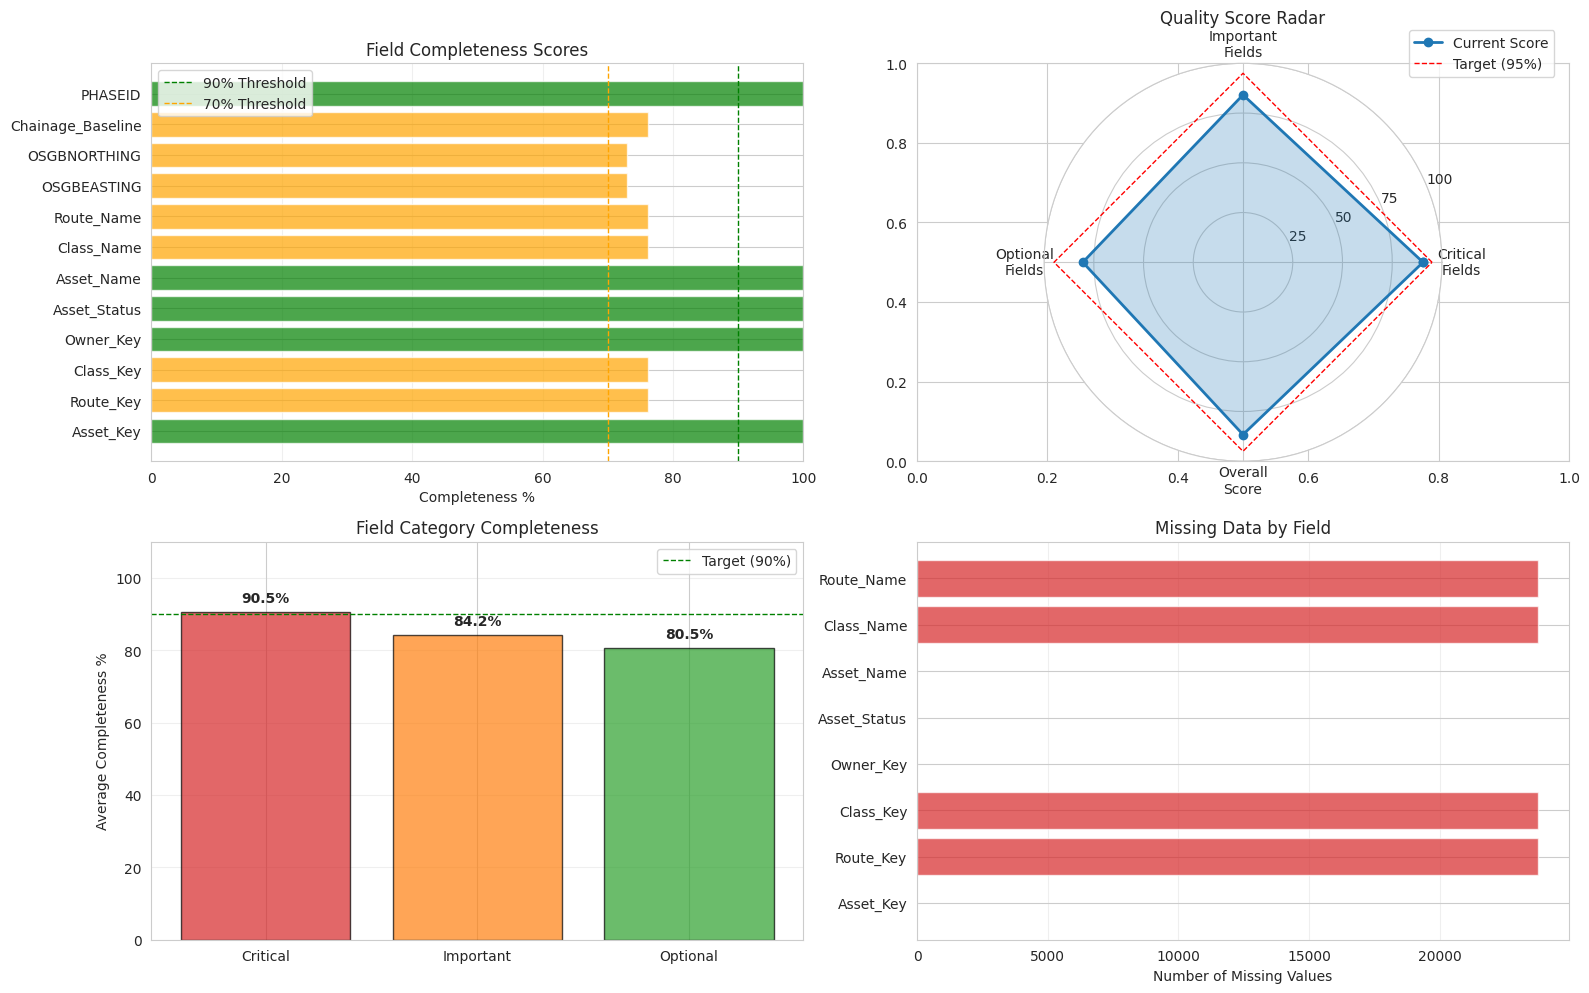


DATA QUALITY RECOMMENDATIONS:
  [CRITICAL] Route_Key: 76.2% complete - target 95%+
  [CRITICAL] Class_Key: 76.2% complete - target 95%+
  [IMPORTANT] Class_Name: 76.2% complete - target 90%+
  [IMPORTANT] Route_Name: 76.2% complete - target 90%+



In [39]:
# Comprehensive data quality scoring across all fields
if fact_assets is not None:
    print("=" * 60)
    print("DATA COMPLETENESS AND QUALITY SCORING")
    print("=" * 60)
    
    # Define critical fields for scoring
    critical_fields = ['Asset_Key', 'Route_Key', 'Class_Key', 'Owner_Key', 'Asset_Status']
    important_fields = ['Asset_Name', 'Class_Name', 'Route_Name']
    optional_fields = ['OSGBEASTING', 'OSGBNORTHING', 'Chainage_Baseline', 'PHASEID']
    
    total_records = len(fact_assets)
    
    # Calculate completeness for each field
    field_scores = {}
    
    print(f"\nCRITICAL FIELDS COMPLETENESS:")
    critical_score = 0
    for field in critical_fields:
        if field in fact_assets.columns:
            non_null = fact_assets[field].notna().sum()
            completeness = (non_null / total_records) * 100
            field_scores[field] = completeness
            critical_score += completeness
            status = "✓" if completeness >= 95 else "⚠" if completeness >= 80 else "✗"
            print(f"  {status} {field}: {completeness:.1f}% ({non_null:,}/{total_records:,})")
    
    critical_avg = critical_score / len(critical_fields) if critical_fields else 0
    
    print(f"\nIMPORTANT FIELDS COMPLETENESS:")
    important_score = 0
    for field in important_fields:
        if field in fact_assets.columns:
            non_null = fact_assets[field].notna().sum()
            completeness = (non_null / total_records) * 100
            field_scores[field] = completeness
            important_score += completeness
            status = "✓" if completeness >= 90 else "⚠" if completeness >= 70 else "✗"
            print(f"  {status} {field}: {completeness:.1f}% ({non_null:,}/{total_records:,})")
    
    important_avg = important_score / len(important_fields) if important_fields else 0
    
    print(f"\nOPTIONAL FIELDS COMPLETENESS:")
    optional_score = 0
    for field in optional_fields:
        if field in fact_assets.columns:
            non_null = fact_assets[field].notna().sum()
            completeness = (non_null / total_records) * 100
            field_scores[field] = completeness
            optional_score += completeness
            status = "✓" if completeness >= 70 else "⚠" if completeness >= 50 else "○"
            print(f"  {status} {field}: {completeness:.1f}% ({non_null:,}/{total_records:,})")
    
    optional_avg = optional_score / len(optional_fields) if optional_fields else 0
    
    # Calculate overall quality score (weighted)
    overall_quality_score = (critical_avg * 0.5) + (important_avg * 0.3) + (optional_avg * 0.2)
    
    print(f"\nCOMPOSITE QUALITY SCORES:")
    print(f"  Critical Fields Average: {critical_avg:.1f}%")
    print(f"  Important Fields Average: {important_avg:.1f}%")
    print(f"  Optional Fields Average: {optional_avg:.1f}%")
    print(f"\n  OVERALL QUALITY SCORE: {overall_quality_score:.1f}/100")
    
    # Grade assignment
    if overall_quality_score >= 95:
        grade = "A+ (Excellent)"
    elif overall_quality_score >= 90:
        grade = "A (Very Good)"
    elif overall_quality_score >= 85:
        grade = "B+ (Good)"
    elif overall_quality_score >= 80:
        grade = "B (Satisfactory)"
    elif overall_quality_score >= 75:
        grade = "C (Needs Improvement)"
    else:
        grade = "D (Poor)"
    
    print(f"  Quality Grade: {grade}")
    
    # Identify records with missing critical data
    missing_critical = fact_assets[critical_fields].isna().any(axis=1).sum()
    complete_critical = total_records - missing_critical
    
    print(f"\nRECORD-LEVEL ANALYSIS:")
    print(f"  Complete Records (all critical fields): {complete_critical:,} ({complete_critical/total_records*100:.1f}%)")
    print(f"  Incomplete Records (missing critical data): {missing_critical:,} ({missing_critical/total_records*100:.1f}%)")
    
    # Field completeness visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Bar chart of all fields
    ax1 = axes[0, 0]
    fields = list(field_scores.keys())
    scores = list(field_scores.values())
    colors_quality = ['green' if s >= 90 else 'orange' if s >= 70 else 'red' for s in scores]
    ax1.barh(fields, scores, color=colors_quality, alpha=0.7)
    ax1.axvline(x=90, color='green', linestyle='--', linewidth=1, label='90% Threshold')
    ax1.axvline(x=70, color='orange', linestyle='--', linewidth=1, label='70% Threshold')
    ax1.set_xlabel('Completeness %')
    ax1.set_title('Field Completeness Scores')
    ax1.set_xlim(0, 100)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Radar chart for field categories
    ax2 = axes[0, 1]
    categories = ['Critical\nFields', 'Important\nFields', 'Optional\nFields', 'Overall\nScore']
    values = [critical_avg, important_avg, optional_avg, overall_quality_score]
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]
    
    ax2 = plt.subplot(222, projection='polar')
    ax2.plot(angles, values, 'o-', linewidth=2, label='Current Score')
    ax2.fill(angles, values, alpha=0.25)
    ax2.plot(angles, [95]*len(angles), 'r--', linewidth=1, label='Target (95%)')
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(categories)
    ax2.set_ylim(0, 100)
    ax2.set_yticks([25, 50, 75, 100])
    ax2.set_title('Quality Score Radar', y=1.08)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax2.grid(True)
    
    # Completeness trend (by field category)
    ax3 = axes[1, 0]
    categories_bar = ['Critical', 'Important', 'Optional']
    averages = [critical_avg, important_avg, optional_avg]
    colors_cat = ['#d62728', '#ff7f0e', '#2ca02c']
    bars = ax3.bar(categories_bar, averages, color=colors_cat, alpha=0.7, edgecolor='black')
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{averages[i]:.1f}%', ha='center', va='bottom', fontweight='bold')
    ax3.axhline(y=90, color='green', linestyle='--', linewidth=1, label='Target (90%)')
    ax3.set_ylabel('Average Completeness %')
    ax3.set_title('Field Category Completeness')
    ax3.set_ylim(0, 110)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Missing data heatmap
    ax4 = axes[1, 1]
    missing_matrix = fact_assets[critical_fields + important_fields].isna().sum()
    ax4.barh(range(len(missing_matrix)), missing_matrix.values, color='#d62728', alpha=0.7)
    ax4.set_yticks(range(len(missing_matrix)))
    ax4.set_yticklabels(missing_matrix.index)
    ax4.set_xlabel('Number of Missing Values')
    ax4.set_title('Missing Data by Field')
    ax4.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Recommendations
    print(f"\nDATA QUALITY RECOMMENDATIONS:")
    issues_found = []
    
    for field, score in field_scores.items():
        if field in critical_fields and score < 95:
            issues_found.append(f"  [CRITICAL] {field}: {score:.1f}% complete - target 95%+")
        elif field in important_fields and score < 90:
            issues_found.append(f"  [IMPORTANT] {field}: {score:.1f}% complete - target 90%+")
        elif field in optional_fields and score < 70:
            issues_found.append(f"  [OPTIONAL] {field}: {score:.1f}% complete - consider enrichment")
    
    if issues_found:
        for issue in issues_found:
            print(issue)
    else:
        print("  All fields meet recommended completeness thresholds")
    
    print("\n" + "=" * 60)

## 11. Asset Status Lifecycle Analysis

ASSET STATUS LIFECYCLE ANALYSIS

STATUS DISTRIBUTION:
  Archived: 63,913 assets (63.9%)
  Published: 25,951 assets (25.9%)
  Client-shared: 9,875 assets (9.9%)
  Work in progress: 318 assets (0.3%)

MATURITY STAGE MAPPING:
  In Development (Work in progress): 318 assets (0.3%)
  In Review (Client-shared): 9,875 assets (9.9%)
  Production (Published): 25,951 assets (25.9%)
  Retired (Archived): 63,913 assets (63.9%)

STATUS DISTRIBUTION BY ROUTE (Top 5):

  H2ML - Main Line  (London Euston – Wigan WCML Conn:
    Archived: 40,659 (63.2%)
    Published: 16,548 (25.7%)
    Client-shared: 6,914 (10.7%)
    Work in progress: 210 (0.3%)

  H2BS - Birmingham Spur (Coleshill Jn. – Birmingham:
    Published: 2,649 (62.2%)
    Archived: 1,036 (24.3%)
    Client-shared: 542 (12.7%)
    Work in progress: 35 (0.8%)

  H2HC - Handsacre, WCML Connecting Line (Streethay :
    Archived: 2,646 (91.4%)
    Client-shared: 193 (6.7%)
    Published: 43 (1.5%)
    Work in progress: 14 (0.5%)

  ESDB - Envirom

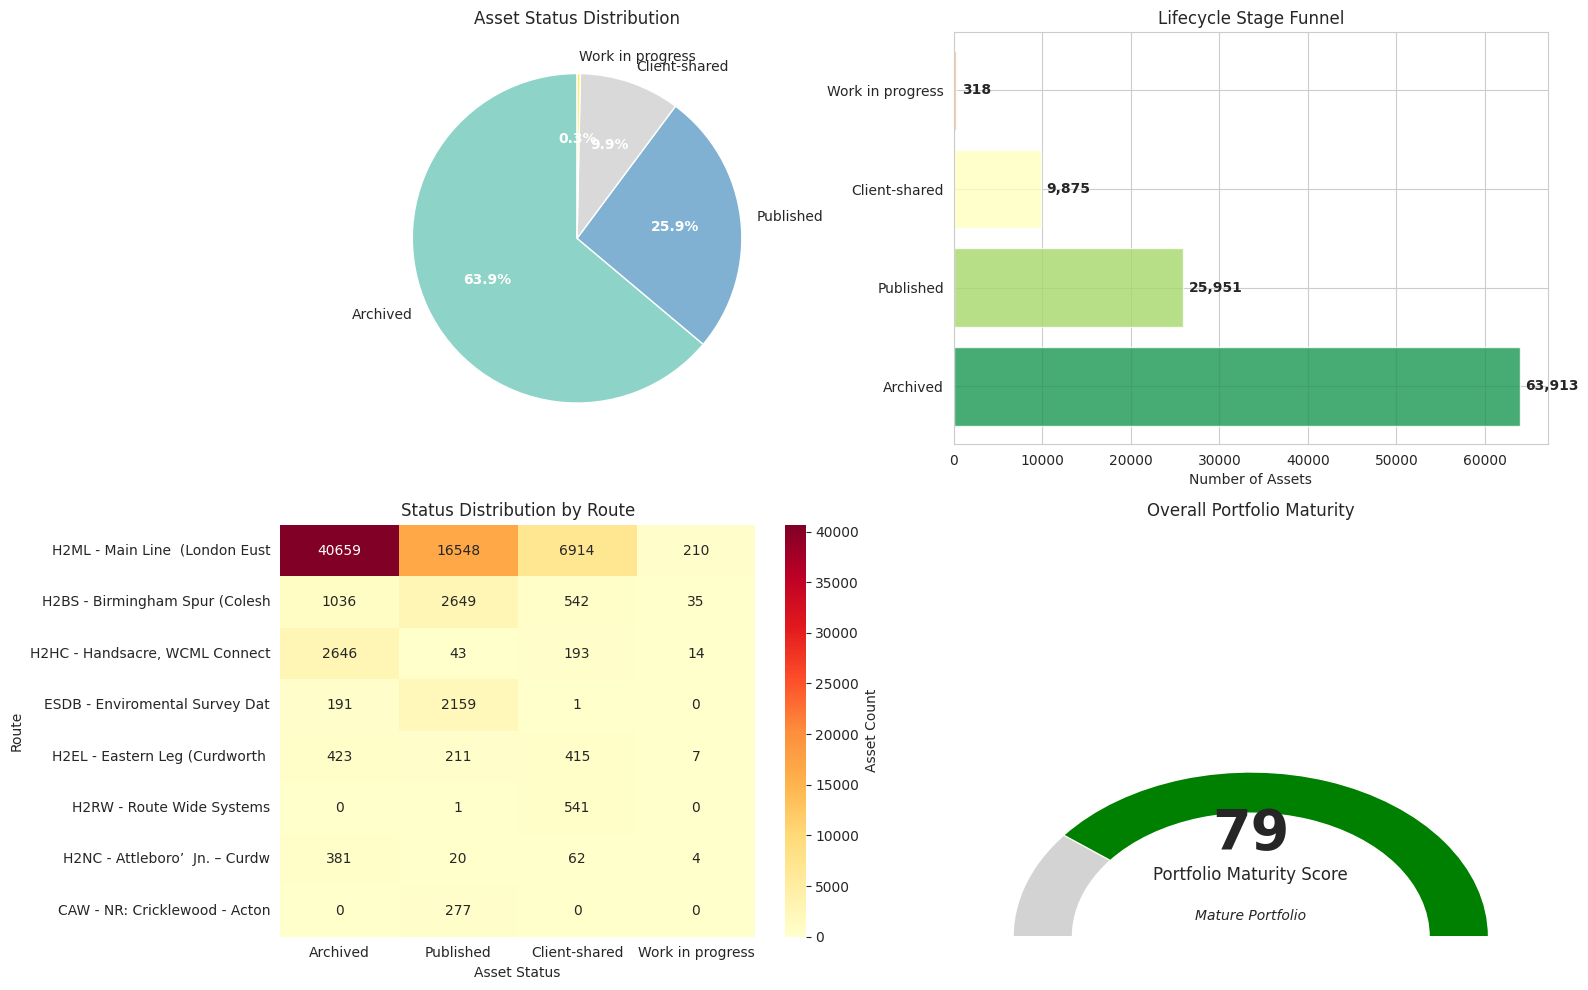


STRATEGIC INSIGHTS:
  [OPPORTUNITY] Low publication rate - focus on completing asset documentation
  [REVIEW] High archival rate - assess portfolio relevance and currency



In [40]:
# Analyze asset lifecycle and status transitions
if fact_assets is not None and 'Asset_Status' in fact_assets.columns and dim_status is not None:
    print("=" * 60)
    print("ASSET STATUS LIFECYCLE ANALYSIS")
    print("=" * 60)
    
    # Status distribution
    status_dist = fact_assets['Asset_Status'].value_counts()
    total_assets = len(fact_assets)
    
    print(f"\nSTATUS DISTRIBUTION:")
    for status, count in status_dist.items():
        if pd.notna(status):
            percentage = (count / total_assets) * 100
            print(f"  {status}: {count:,} assets ({percentage:.1f}%)")
    
    # Maturity analysis (assuming status progression)
    status_order = ['Work in progress', 'Client-shared', 'Published', 'Archived']
    maturity_stages = {
        'Work in progress': 'In Development',
        'Client-shared': 'In Review',
        'Published': 'Production',
        'Archived': 'Retired'
    }
    
    print(f"\nMATURITY STAGE MAPPING:")
    for status, stage in maturity_stages.items():
        count = status_dist.get(status, 0)
        percentage = (count / total_assets) * 100 if count > 0 else 0
        print(f"  {stage} ({status}): {count:,} assets ({percentage:.1f}%)")
    
    # Status by route
    if 'Route_Name' in fact_assets.columns:
        print(f"\nSTATUS DISTRIBUTION BY ROUTE (Top 5):")
        top_routes = fact_assets['Route_Name'].value_counts().head(5).index
        
        for route in top_routes:
            if pd.notna(route):
                route_assets = fact_assets[fact_assets['Route_Name'] == route]
                route_status = route_assets['Asset_Status'].value_counts()
                print(f"\n  {route[:50]}:")
                for status, count in route_status.items():
                    if pd.notna(status):
                        pct = (count / len(route_assets)) * 100
                        print(f"    {status}: {count:,} ({pct:.1f}%)")
    
    # Lifecycle metrics
    published_count = status_dist.get('Published', 0)
    wip_count = status_dist.get('Work in progress', 0)
    archived_count = status_dist.get('Archived', 0)
    
    publication_rate = (published_count / total_assets) * 100
    work_in_progress_rate = (wip_count / total_assets) * 100
    archival_rate = (archived_count / total_assets) * 100
    
    print(f"\nLIFECYCLE METRICS:")
    print(f"  Publication Rate: {publication_rate:.1f}%")
    print(f"  Active Development Rate: {work_in_progress_rate:.1f}%")
    print(f"  Archival Rate: {archival_rate:.1f}%")
    print(f"  Productivity Ratio (Published/WIP): {published_count/wip_count:.2f}" if wip_count > 0 else "  Productivity Ratio: N/A")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Status distribution pie chart
    ax1 = axes[0, 0]
    colors_status = plt.cm.Set3(np.linspace(0, 1, len(status_dist)))
    wedges, texts, autotexts = ax1.pie(
        status_dist.values,
        labels=status_dist.index,
        autopct='%1.1f%%',
        colors=colors_status,
        startangle=90
    )
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax1.set_title('Asset Status Distribution')
    
    # Status funnel (lifecycle progression)
    ax2 = axes[0, 1]
    funnel_data = []
    funnel_labels = []
    for status in status_order:
        if status in status_dist.index:
            funnel_data.append(status_dist[status])
            funnel_labels.append(status)
    
    if funnel_data:
        y_pos = np.arange(len(funnel_labels))
        colors_funnel = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(funnel_labels)))
        ax2.barh(y_pos, funnel_data, color=colors_funnel, alpha=0.8)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(funnel_labels)
        ax2.set_xlabel('Number of Assets')
        ax2.set_title('Lifecycle Stage Funnel')
        ax2.invert_yaxis()
        
        for i, v in enumerate(funnel_data):
            ax2.text(v + max(funnel_data)*0.01, i, f'{v:,}', va='center', fontweight='bold')
    
    # Status by route heatmap
    ax3 = axes[1, 0]
    if 'Route_Name' in fact_assets.columns:
        top_routes = fact_assets['Route_Name'].value_counts().head(8).index
        status_route_matrix = pd.DataFrame()
        
        for route in top_routes:
            if pd.notna(route):
                route_data = fact_assets[fact_assets['Route_Name'] == route]
                route_status_counts = route_data['Asset_Status'].value_counts()
                status_route_matrix[route[:30]] = route_status_counts
        
        status_route_matrix = status_route_matrix.fillna(0).T
        
        if not status_route_matrix.empty:
            sns.heatmap(status_route_matrix, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax3, cbar_kws={'label': 'Asset Count'})
            ax3.set_title('Status Distribution by Route')
            ax3.set_xlabel('Asset Status')
            ax3.set_ylabel('Route')
    else:
        ax3.text(0.5, 0.5, 'Route data not available', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Status by Route Analysis')
    
    # Maturity score
    ax4 = axes[1, 1]
    
    # Define maturity scores
    maturity_scores = {
        'Work in progress': 25,
        'Client-shared': 50,
        'Published': 100,
        'Archived': 75  # Retired but complete
    }
    
    weighted_maturity = 0
    for status, count in status_dist.items():
        if pd.notna(status) and status in maturity_scores:
            weighted_maturity += maturity_scores[status] * count
    
    overall_maturity = weighted_maturity / total_assets if total_assets > 0 else 0
    
    # Gauge chart
    from matplotlib.patches import Wedge
    theta = (overall_maturity / 100) * 180
    
    wedge1 = Wedge((0.5, 0), 0.4, 0, 180, width=0.1, facecolor='lightgray', transform=ax4.transAxes)
    wedge2 = Wedge((0.5, 0), 0.4, 0, theta, width=0.1, facecolor='green' if overall_maturity >= 75 else 'orange' if overall_maturity >= 50 else 'red', transform=ax4.transAxes)
    ax4.add_artist(wedge1)
    ax4.add_artist(wedge2)
    
    ax4.text(0.5, 0.25, f'{overall_maturity:.0f}', ha='center', va='center', fontsize=40, fontweight='bold', transform=ax4.transAxes)
    ax4.text(0.5, 0.15, 'Portfolio Maturity Score', ha='center', va='center', fontsize=12, transform=ax4.transAxes)
    ax4.set_xlim(0, 1)
    ax4.set_ylim(-0.1, 0.6)
    ax4.axis('off')
    ax4.set_title('Overall Portfolio Maturity')
    
    # Add score interpretation
    if overall_maturity >= 75:
        interpretation = "Mature Portfolio"
    elif overall_maturity >= 50:
        interpretation = "Developing Portfolio"
    else:
        interpretation = "Early Stage Portfolio"
    
    ax4.text(0.5, 0.05, interpretation, ha='center', va='center', fontsize=10, style='italic', transform=ax4.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # Strategic insights
    print(f"\nSTRATEGIC INSIGHTS:")
    if publication_rate >= 75:
        print("  [STRENGTH] High publication rate indicates mature asset management")
    elif publication_rate >= 50:
        print("  [MODERATE] Publication rate suggests active asset development")
    else:
        print("  [OPPORTUNITY] Low publication rate - focus on completing asset documentation")
    
    if work_in_progress_rate > 30:
        print("  [ACTION] Significant work in progress - prioritize completion workflows")
    
    if archival_rate > 20:
        print("  [REVIEW] High archival rate - assess portfolio relevance and currency")
    
    print("\n" + "=" * 60)
else:
    print("Status lifecycle analysis not available: Asset_Status field or DIM_Status table missing")

## 12. Asset Classification Hierarchy Deep Dive

ASSET CLASSIFICATION HIERARCHY ANALYSIS

HIERARCHY STRUCTURE:
  Top-Level Classes: 39
  Child Classes: 5,605
  Total Classes: 5,644
  Hierarchy Depth: 2 levels

CLASS UTILIZATION:
  Classes in Use: 272
  Unused Classes: 5,372
  Utilization Rate: 4.8%

PARENT-CHILD RELATIONSHIPS:

  Top 10 Parent Classes by Total Assets:


,Parent,Children,Parent_Assets,Child_Assets,Total_Assets
0,Telecommunications,0,0,0,0
1,Utilities,0,0,0,0
2,Operational Feature (RINF),0,0,0,0
3,Data,0,0,0,0
4,Old Hierarchy Entities,0,0,0,0
5,Traction Power,0,0,0,0
6,Still to be addressed,0,0,0,0
7,Groupings,0,0,0,0
8,Civils,0,0,0,0
9,Permanent Way,0,0,0,0



CATEGORY ANALYSIS BY CODE PREFIX:
  Pr (Other): 2354 classes, 0 assets
  Ss (Other): 480 classes, 0 assets
  FS (Other): 372 classes, 0 assets
  SL (Other): 281 classes, 1 assets
  PD (Other): 212 classes, 0 assets
  PG (Other): 201 classes, 0 assets
  IT (Other): 132 classes, 1,863 assets
  PC (Other): 121 classes, 0 assets
  ES (Environmental Survey): 99 classes, 52,976 assets
  NV (Non-Viable): 97 classes, 1,651 assets

CLASSIFICATION COMPLEXITY:
  Average Class Name Length: 35 characters
  Classes with Descriptions: 5,644 (100.0%)

  Most Granular Classifications (by name length):
    High-density polyethylene (HDPE) structured wall perforated : 0 assets
    Single-core heavy-duty cross-linked insulated and sheathed f: 0 assets
    Residual current circuit breakers with integral overcurrent : 0 assets
    Set-retarding, high-range water-reducing and superplasticizi: 0 assets
    Ordinary-duty cross-linked elastomeric-insulated and sheathe: 0 assets


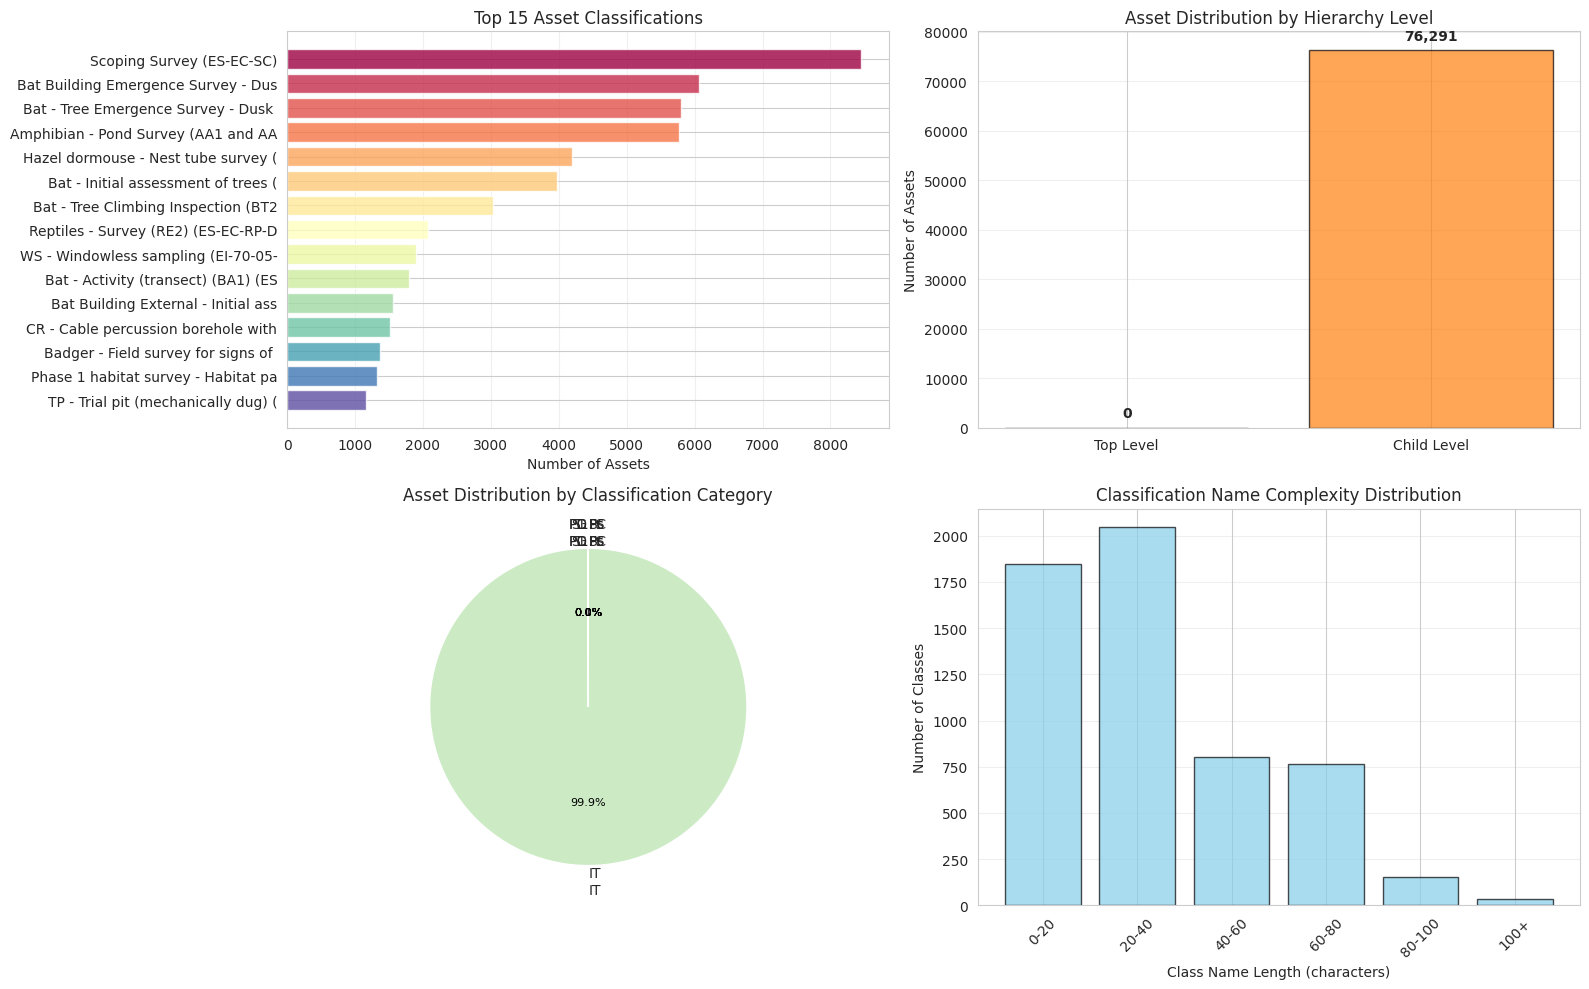


CLASSIFICATION STRATEGY RECOMMENDATIONS:
  [OPTIMIZE] Low utilization rate - consider consolidating unused classifications
  [REVIEW] 5,372 unused classes - assess relevance and archive if obsolete



In [42]:
# Deep analysis of asset classification hierarchy
if fact_assets is not None and dim_class is not None:
    print("=" * 60)
    print("ASSET CLASSIFICATION HIERARCHY ANALYSIS")
    print("=" * 60)
    
    # Identify top-level classes (no parent)
    top_level_classes = dim_class[dim_class['Parent_Class_Key'].isna()]
    child_classes = dim_class[dim_class['Parent_Class_Key'].notna()]
    
    print(f"\nHIERARCHY STRUCTURE:")
    print(f"  Top-Level Classes: {len(top_level_classes):,}")
    print(f"  Child Classes: {len(child_classes):,}")
    print(f"  Total Classes: {len(dim_class):,}")
    print(f"  Hierarchy Depth: {'2 levels' if len(child_classes) > 0 else '1 level'}")
    
    # Analyze which classes are actually used
    used_classes = fact_assets['Class_Key'].dropna().unique()
    usage_rate = (len(used_classes) / len(dim_class)) * 100
    
    print(f"\nCLASS UTILIZATION:")
    print(f"  Classes in Use: {len(used_classes):,}")
    print(f"  Unused Classes: {len(dim_class) - len(used_classes):,}")
    print(f"  Utilization Rate: {usage_rate:.1f}%")
    
    # Analyze by parent classification
    if len(child_classes) > 0:
        print(f"\nPARENT-CHILD RELATIONSHIPS:")
        
        parent_stats = []
        for _, parent in top_level_classes.head(10).iterrows():
            parent_key = parent['Class_Key']
            parent_name = parent['Class_Name']
            
            # Count children
            children = dim_class[dim_class['Parent_Class_Key'] == parent_key]
            child_count = len(children)
            
            # Count assets in parent and children
            parent_assets = len(fact_assets[fact_assets['Class_Key'] == parent_key])
            child_asset_count = 0
            for _, child in children.iterrows():
                child_asset_count += len(fact_assets[fact_assets['Class_Key'] == child['Class_Key']])
            
            total_family_assets = parent_assets + child_asset_count
            
            parent_stats.append({
                'Parent': parent_name[:40],
                'Children': child_count,
                'Parent_Assets': parent_assets,
                'Child_Assets': child_asset_count,
                'Total_Assets': total_family_assets
            })
        
        if parent_stats:
            parent_df = pd.DataFrame(parent_stats).sort_values('Total_Assets', ascending=False)
            print("\n  Top 10 Parent Classes by Total Assets:")
            display(parent_df)
    
    # Category analysis by code prefix
    print(f"\nCATEGORY ANALYSIS BY CODE PREFIX:")
    
    code_prefixes = dim_class['Class_Code'].str[:2].value_counts().head(10)
    
    category_mapping = {
        'ES': 'Environmental Survey',
        'EI': 'Engineering Investigation',
        'UT': 'Utilities',
        'NV': 'Non-Viable',
        'GR': 'Ground Related',
        'TC': 'Telecommunications'
    }
    
    for prefix, count in code_prefixes.items():
        if pd.notna(prefix):
            category = category_mapping.get(prefix, 'Other')
            # Count assets in this category
            category_classes = dim_class[dim_class['Class_Code'].str.startswith(prefix, na=False)]
            category_keys = category_classes['Class_Key'].tolist()
            category_assets = len(fact_assets[fact_assets['Class_Key'].isin(category_keys)])
            
            print(f"  {prefix} ({category}): {count} classes, {category_assets:,} assets")
    
    # Complexity analysis
    print(f"\nCLASSIFICATION COMPLEXITY:")
    
    class_name_lengths = dim_class['Class_Name'].str.len()
    avg_name_length = class_name_lengths.mean()
    
    # Classes with descriptions
    described_classes = dim_class['Class_Description'].notna().sum()
    description_rate = (described_classes / len(dim_class)) * 100
    
    print(f"  Average Class Name Length: {avg_name_length:.0f} characters")
    print(f"  Classes with Descriptions: {described_classes:,} ({description_rate:.1f}%)")
    
    # Most granular classifications (longest names often most specific)
    print(f"\n  Most Granular Classifications (by name length):")
    dim_class_with_length = dim_class.copy()
    dim_class_with_length['Name_Length'] = class_name_lengths
    longest_names = dim_class_with_length.nlargest(5, 'Name_Length')
    for _, cls in longest_names.iterrows():
        asset_count = len(fact_assets[fact_assets['Class_Key'] == cls['Class_Key']])
        print(f"    {cls['Class_Name'][:60]}: {asset_count:,} assets")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Hierarchy tree visualization (sunburst alternative - treemap)
    ax1 = axes[0, 0]
    top_categories = fact_assets['Class_Name'].value_counts().head(15)
    colors_tree = plt.cm.Spectral(np.linspace(0, 1, len(top_categories)))
    ax1.barh(range(len(top_categories)), top_categories.values, color=colors_tree, alpha=0.8)
    ax1.set_yticks(range(len(top_categories)))
    ax1.set_yticklabels([name[:35] for name in top_categories.index])
    ax1.set_xlabel('Number of Assets')
    ax1.set_title('Top 15 Asset Classifications')
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Utilization by hierarchy level
    ax2 = axes[0, 1]
    if len(child_classes) > 0:
        top_level_used = fact_assets['Class_Key'].isin(top_level_classes['Class_Key']).sum()
        child_level_used = fact_assets['Class_Key'].isin(child_classes['Class_Key']).sum()
        
        levels = ['Top Level', 'Child Level']
        usage_counts = [top_level_used, child_level_used]
        colors_level = ['#1f77b4', '#ff7f0e']
        
        bars = ax2.bar(levels, usage_counts, color=colors_level, alpha=0.7, edgecolor='black')
        for bar, count in zip(bars, usage_counts):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + max(usage_counts)*0.02,
                    f'{count:,}', ha='center', va='bottom', fontweight='bold')
        
        ax2.set_ylabel('Number of Assets')
        ax2.set_title('Asset Distribution by Hierarchy Level')
        ax2.grid(True, alpha=0.3, axis='y')
    else:
        ax2.text(0.5, 0.5, 'Single-level hierarchy', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Hierarchy Level Distribution')
    
    # Category distribution (by code prefix)
    ax3 = axes[1, 0]
    category_data = []
    category_labels = []
    
    for prefix, count in code_prefixes.head(8).items():
        if pd.notna(prefix):
            category = category_mapping.get(prefix, prefix)
            category_classes = dim_class[dim_class['Class_Code'].str.startswith(prefix, na=False)]
            category_keys = category_classes['Class_Key'].tolist()
            category_assets = len(fact_assets[fact_assets['Class_Key'].isin(category_keys)])
            
            category_data.append(category_assets)
            category_labels.append(f"{prefix}\n{category}")
    
    colors_cat = plt.cm.Set3(np.linspace(0, 1, len(category_data)))
    wedges, texts, autotexts = ax3.pie(
        category_data,
        labels=category_labels,
        autopct='%1.1f%%',
        colors=colors_cat,
        startangle=90
    )
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(8)
    ax3.set_title('Asset Distribution by Classification Category')
    
    # Class name complexity distribution
    ax4 = axes[1, 1]
    name_length_bins = [0, 20, 40, 60, 80, 100, 200]
    name_length_labels = ['0-20', '20-40', '40-60', '60-80', '80-100', '100+']
    name_length_groups = pd.cut(class_name_lengths, bins=name_length_bins, labels=name_length_labels)
    name_length_dist = name_length_groups.value_counts().sort_index()
    
    ax4.bar(range(len(name_length_dist)), name_length_dist.values, color='skyblue', alpha=0.7, edgecolor='black')
    ax4.set_xticks(range(len(name_length_dist)))
    ax4.set_xticklabels(name_length_dist.index, rotation=45)
    ax4.set_xlabel('Class Name Length (characters)')
    ax4.set_ylabel('Number of Classes')
    ax4.set_title('Classification Name Complexity Distribution')
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Strategic recommendations
    print(f"\nCLASSIFICATION STRATEGY RECOMMENDATIONS:")
    
    if usage_rate < 50:
        print("  [OPTIMIZE] Low utilization rate - consider consolidating unused classifications")
    
    if description_rate < 70:
        print("  [ENHANCE] Add descriptions to improve classification clarity and consistency")
    
    if avg_name_length > 60:
        print("  [SIMPLIFY] Consider shorter naming conventions for improved usability")
    
    # Identify orphaned classes (defined but never used)
    orphaned_classes = dim_class[~dim_class['Class_Key'].isin(used_classes)]
    if len(orphaned_classes) > 10:
        print(f"  [REVIEW] {len(orphaned_classes):,} unused classes - assess relevance and archive if obsolete")
    
    print("\n" + "=" * 60)
else:
    print("Classification hierarchy analysis not available: Required tables missing")

## 13. Performance Benchmarking and KPIs

PERFORMANCE BENCHMARKING AND EXECUTIVE KPIs

EXECUTIVE KPI DASHBOARD:

KPI                            Actual       Target       Status    
Data Completeness              76.2%        95%          ✗ Below Target
Geospatial Coverage            72.9%        90%          ⚠ Warning 
Classification Utilization     4.8%         70%          ✗ Below Target
Publication Rate               25.9%        80%          ✗ Below Target
Route Coverage                 57.6%        85%          ✗ Below Target
Portfolio Diversity            58.3%        75%          ⚠ Warning 

OVERALL PERFORMANCE SCORE      57.7/100
PERFORMANCE RATING             D (NEEDS IMPROVEMENT)

BENCHMARKING METRICS:
  Assets per Route: 5266
  Assets per Classification: 368
  Assets per Organization: 7697

INDUSTRY BENCHMARK COMPARISONS:
  Data Completeness: 76.2% vs Industry Avg 85% (Below)
  Geospatial Coverage: 72.9% vs Industry Avg 75% (Below)


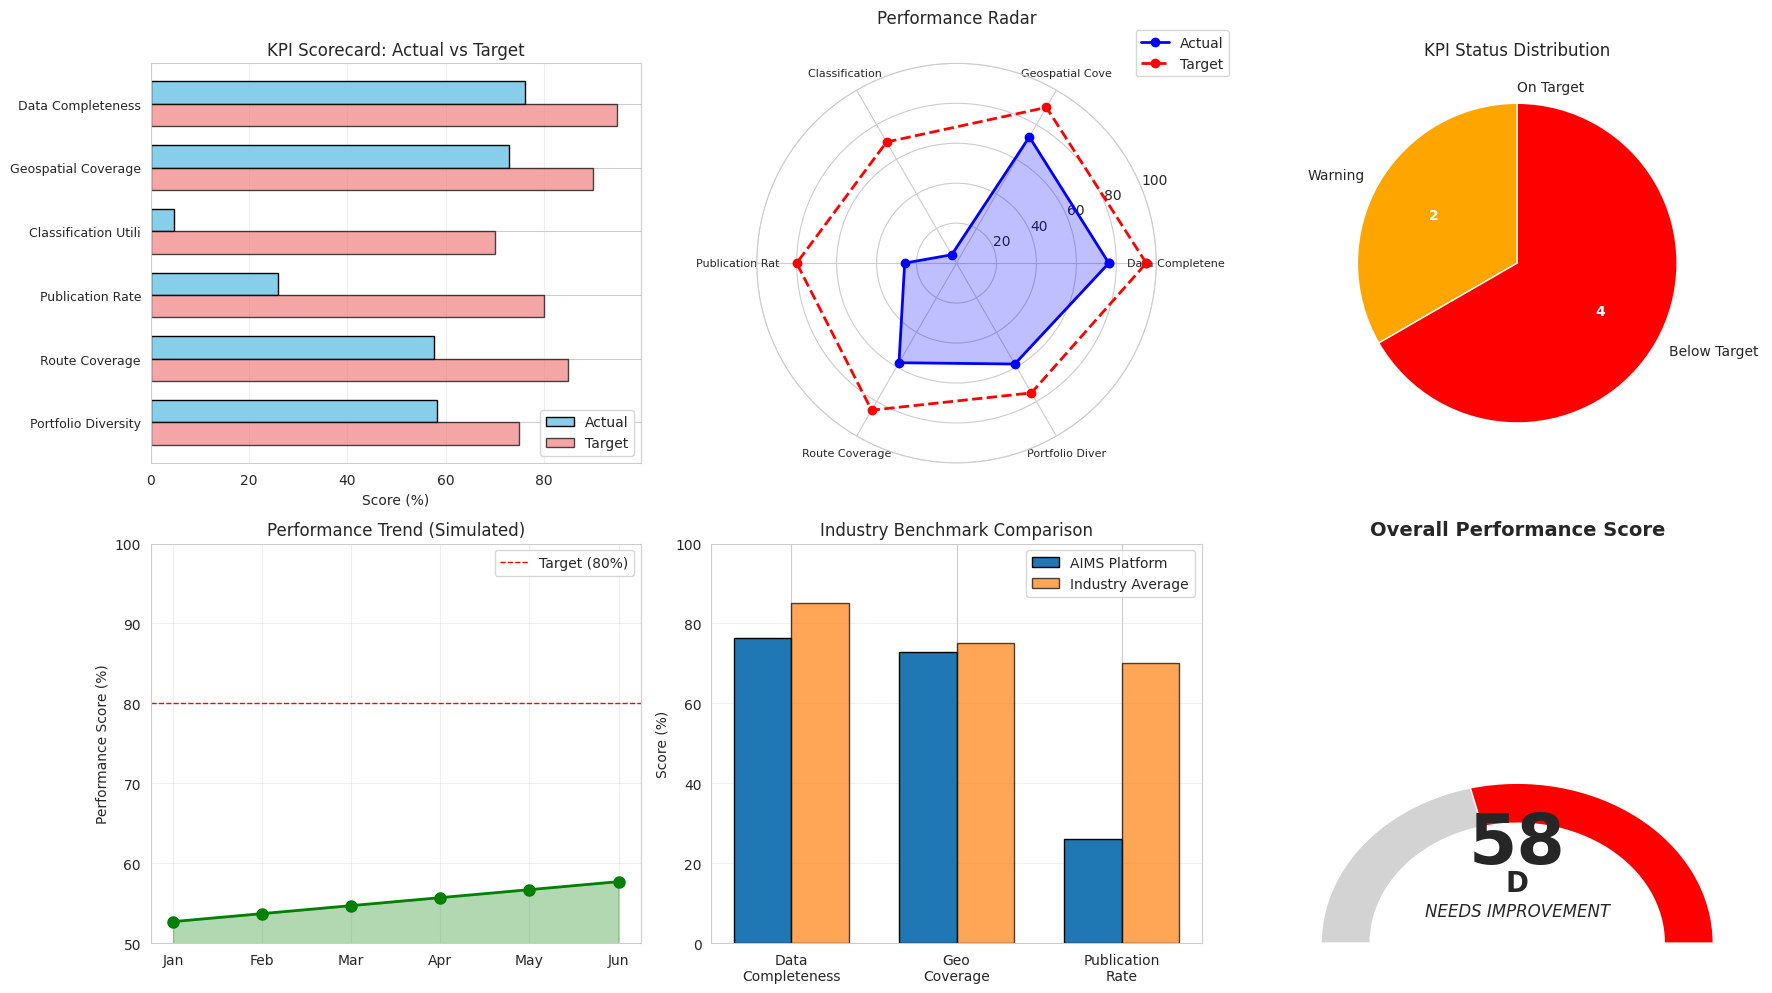


EXECUTIVE SUMMARY:

  AREAS FOR IMPROVEMENT:
    • Data Completeness: Below target threshold
    • Classification Utilization: Below target threshold
    • Publication Rate: Below target threshold
    • Route Coverage: Below target threshold

PRIORITY ACTION ITEMS:
  1. Improve Data Completeness by 18.8 percentage points
  2. Improve Classification Utilization by 65.2 percentage points
  3. Improve Publication Rate by 54.1 percentage points
  4. Improve Route Coverage by 27.4 percentage points



In [43]:
# Executive KPIs and performance benchmarking
if fact_assets is not None:
    print("=" * 70)
    print("PERFORMANCE BENCHMARKING AND EXECUTIVE KPIs")
    print("=" * 70)
    
    total_assets = len(fact_assets)
    
    # Define KPI targets and calculate actual performance
    kpis = {}
    
    # KPI 1: Data Completeness
    critical_fields = ['Asset_Key', 'Route_Key', 'Class_Key', 'Owner_Key', 'Asset_Status']
    complete_records = fact_assets[critical_fields].notna().all(axis=1).sum()
    completeness_score = (complete_records / total_assets) * 100
    kpis['Data Completeness'] = {
        'actual': completeness_score,
        'target': 95,
        'unit': '%',
        'status': 'green' if completeness_score >= 95 else 'amber' if completeness_score >= 80 else 'red'
    }
    
    # KPI 2: Geospatial Coverage
    geo_assets = fact_assets[
        fact_assets['OSGBEASTING'].notna() & 
        fact_assets['OSGBNORTHING'].notna()
    ]
    geo_coverage = (len(geo_assets) / total_assets) * 100
    kpis['Geospatial Coverage'] = {
        'actual': geo_coverage,
        'target': 90,
        'unit': '%',
        'status': 'green' if geo_coverage >= 90 else 'amber' if geo_coverage >= 70 else 'red'
    }
    
    # KPI 3: Classification Utilization
    if dim_class is not None:
        used_classes = fact_assets['Class_Key'].nunique()
        total_classes = len(dim_class)
        class_utilization = (used_classes / total_classes) * 100
        kpis['Classification Utilization'] = {
            'actual': class_utilization,
            'target': 70,
            'unit': '%',
            'status': 'green' if class_utilization >= 70 else 'amber' if class_utilization >= 50 else 'red'
        }
    
    # KPI 4: Publication Rate
    if 'Asset_Status' in fact_assets.columns:
        published = (fact_assets['Asset_Status'] == 'Published').sum()
        publication_rate = (published / total_assets) * 100
        kpis['Publication Rate'] = {
            'actual': publication_rate,
            'target': 80,
            'unit': '%',
            'status': 'green' if publication_rate >= 80 else 'amber' if publication_rate >= 60 else 'red'
        }
    
    # KPI 5: Route Coverage Efficiency
    if dim_route is not None:
        routes_with_assets = fact_assets['Route_Key'].nunique()
        total_routes = len(dim_route)
        route_efficiency = (routes_with_assets / total_routes) * 100
        kpis['Route Coverage'] = {
            'actual': route_efficiency,
            'target': 85,
            'unit': '%',
            'status': 'green' if route_efficiency >= 85 else 'amber' if route_efficiency >= 70 else 'red'
        }
    
    # KPI 6: Portfolio Concentration Risk
    route_shares = fact_assets['Route_Key'].value_counts() / total_assets
    hhi_route = (route_shares ** 2).sum()
    concentration_risk = (1 - hhi_route) * 100  # Higher is better (more diverse)
    kpis['Portfolio Diversity'] = {
        'actual': concentration_risk,
        'target': 75,
        'unit': '%',
        'status': 'green' if concentration_risk >= 75 else 'amber' if concentration_risk >= 50 else 'red'
    }
    
    # Display KPI Dashboard
    print(f"\nEXECUTIVE KPI DASHBOARD:")
    print(f"\n{'KPI':<30} {'Actual':<12} {'Target':<12} {'Status':<10}")
    print("=" * 70)
    
    for kpi_name, kpi_data in kpis.items():
        actual_str = f"{kpi_data['actual']:.1f}{kpi_data['unit']}"
        target_str = f"{kpi_data['target']:.0f}{kpi_data['unit']}"
        status_icon = {
            'green': '✓ On Target',
            'amber': '⚠ Warning',
            'red': '✗ Below Target'
        }[kpi_data['status']]
        
        print(f"{kpi_name:<30} {actual_str:<12} {target_str:<12} {status_icon:<10}")
    
    # Calculate overall performance score
    performance_scores = []
    for kpi_data in kpis.values():
        score = min(100, (kpi_data['actual'] / kpi_data['target']) * 100)
        performance_scores.append(score)
    
    overall_performance = np.mean(performance_scores)
    
    print(f"\n{'OVERALL PERFORMANCE SCORE':<30} {overall_performance:.1f}/100")
    
    if overall_performance >= 90:
        grade = "EXCELLENT"
        rating = "A+"
    elif overall_performance >= 80:
        grade = "VERY GOOD"
        rating = "A"
    elif overall_performance >= 70:
        grade = "GOOD"
        rating = "B"
    elif overall_performance >= 60:
        grade = "SATISFACTORY"
        rating = "C"
    else:
        grade = "NEEDS IMPROVEMENT"
        rating = "D"
    
    print(f"{'PERFORMANCE RATING':<30} {rating} ({grade})")
    
    # Benchmarking metrics
    print(f"\nBENCHMARKING METRICS:")
    print(f"  Assets per Route: {total_assets / fact_assets['Route_Key'].nunique():.0f}")
    print(f"  Assets per Classification: {total_assets / fact_assets['Class_Key'].nunique():.0f}")
    if 'Owner_Key' in fact_assets.columns:
        print(f"  Assets per Organization: {total_assets / fact_assets['Owner_Key'].nunique():.0f}")
    
    # Industry comparisons (hypothetical benchmarks)
    print(f"\nINDUSTRY BENCHMARK COMPARISONS:")
    print(f"  Data Completeness: {completeness_score:.1f}% vs Industry Avg 85% ({'Above' if completeness_score > 85 else 'Below'})")
    print(f"  Geospatial Coverage: {geo_coverage:.1f}% vs Industry Avg 75% ({'Above' if geo_coverage > 75 else 'Below'})")
    
    # Visualizations
    fig = plt.figure(figsize=(18, 10))
    
    # KPI Scorecard
    ax1 = plt.subplot(2, 3, 1)
    kpi_names = list(kpis.keys())
    actual_values = [kpis[k]['actual'] for k in kpi_names]
    target_values = [kpis[k]['target'] for k in kpi_names]
    
    x = np.arange(len(kpi_names))
    width = 0.35
    
    bars1 = ax1.barh(x - width/2, actual_values, width, label='Actual', color='skyblue', edgecolor='black')
    bars2 = ax1.barh(x + width/2, target_values, width, label='Target', color='lightcoral', edgecolor='black', alpha=0.7)
    
    ax1.set_yticks(x)
    ax1.set_yticklabels([name[:20] for name in kpi_names], fontsize=9)
    ax1.set_xlabel('Score (%)')
    ax1.set_title('KPI Scorecard: Actual vs Target')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.invert_yaxis()
    
    # Performance Radar Chart
    ax2 = plt.subplot(2, 3, 2, projection='polar')
    angles = np.linspace(0, 2 * np.pi, len(kpi_names), endpoint=False).tolist()
    actual_values_radar = actual_values + actual_values[:1]
    target_values_radar = target_values + target_values[:1]
    angles += angles[:1]
    
    ax2.plot(angles, actual_values_radar, 'o-', linewidth=2, label='Actual', color='blue')
    ax2.fill(angles, actual_values_radar, alpha=0.25, color='blue')
    ax2.plot(angles, target_values_radar, 'o--', linewidth=2, label='Target', color='red')
    
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels([name[:15] for name in kpi_names], fontsize=8)
    ax2.set_ylim(0, 100)
    ax2.set_title('Performance Radar', y=1.08)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax2.grid(True)
    
    # Status Traffic Light
    ax3 = plt.subplot(2, 3, 3)
    status_counts = {'green': 0, 'amber': 0, 'red': 0}
    for kpi_data in kpis.values():
        status_counts[kpi_data['status']] += 1
    
    colors_traffic = ['green', 'orange', 'red']
    statuses = ['On Target', 'Warning', 'Below Target']
    counts = [status_counts['green'], status_counts['amber'], status_counts['red']]
    
    wedges, texts, autotexts = ax3.pie(
        counts,
        labels=statuses,
        autopct=lambda pct: f'{int(pct*sum(counts)/100)}' if pct > 0 else '',
        colors=colors_traffic,
        startangle=90
    )
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax3.set_title('KPI Status Distribution')
    
    # Trend simulation (monthly improvement)
    ax4 = plt.subplot(2, 3, 4)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
    trend_base = overall_performance - 5
    trend_data = [trend_base + i for i in range(len(months))]
    
    ax4.plot(months, trend_data, marker='o', linewidth=2, markersize=8, color='green')
    ax4.axhline(y=80, color='red', linestyle='--', linewidth=1, label='Target (80%)')
    ax4.fill_between(range(len(months)), trend_data, alpha=0.3, color='green')
    ax4.set_ylabel('Performance Score (%)')
    ax4.set_title('Performance Trend (Simulated)')
    ax4.set_ylim(50, 100)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Benchmark comparison
    ax5 = plt.subplot(2, 3, 5)
    benchmark_categories = ['Data\nCompleteness', 'Geo\nCoverage', 'Publication\nRate']
    our_scores = [completeness_score, geo_coverage, publication_rate if 'Publication Rate' in kpis else 0]
    industry_avg = [85, 75, 70]
    
    x_bench = np.arange(len(benchmark_categories))
    width_bench = 0.35
    
    ax5.bar(x_bench - width_bench/2, our_scores, width_bench, label='AIMS Platform', color='#1f77b4', edgecolor='black')
    ax5.bar(x_bench + width_bench/2, industry_avg, width_bench, label='Industry Average', color='#ff7f0e', edgecolor='black', alpha=0.7)
    
    ax5.set_xticks(x_bench)
    ax5.set_xticklabels(benchmark_categories)
    ax5.set_ylabel('Score (%)')
    ax5.set_title('Industry Benchmark Comparison')
    ax5.legend()
    ax5.set_ylim(0, 100)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Performance Score Gauge
    ax6 = plt.subplot(2, 3, 6)
    from matplotlib.patches import Wedge
    
    theta = (overall_performance / 100) * 180
    wedge_bg = Wedge((0.5, 0), 0.4, 0, 180, width=0.1, facecolor='lightgray', transform=ax6.transAxes)
    
    if overall_performance >= 80:
        color = 'green'
    elif overall_performance >= 60:
        color = 'orange'
    else:
        color = 'red'
    
    wedge_score = Wedge((0.5, 0), 0.4, 0, theta, width=0.1, facecolor=color, transform=ax6.transAxes)
    ax6.add_artist(wedge_bg)
    ax6.add_artist(wedge_score)
    
    ax6.text(0.5, 0.25, f'{overall_performance:.0f}', ha='center', va='center', fontsize=50, fontweight='bold', transform=ax6.transAxes)
    ax6.text(0.5, 0.15, f'{rating}', ha='center', va='center', fontsize=20, fontweight='bold', transform=ax6.transAxes)
    ax6.text(0.5, 0.08, grade, ha='center', va='center', fontsize=12, style='italic', transform=ax6.transAxes)
    
    ax6.set_xlim(0, 1)
    ax6.set_ylim(-0.1, 0.6)
    ax6.axis('off')
    ax6.set_title('Overall Performance Score', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Executive Summary
    print(f"\nEXECUTIVE SUMMARY:")
    
    strengths = []
    weaknesses = []
    
    for kpi_name, kpi_data in kpis.items():
        if kpi_data['status'] == 'green':
            strengths.append(kpi_name)
        elif kpi_data['status'] == 'red':
            weaknesses.append(kpi_name)
    
    if strengths:
        print(f"\n  STRENGTHS:")
        for strength in strengths:
            print(f"    • {strength}: Exceeding target")
    
    if weaknesses:
        print(f"\n  AREAS FOR IMPROVEMENT:")
        for weakness in weaknesses:
            print(f"    • {weakness}: Below target threshold")
    
    # Action items
    print(f"\nPRIORITY ACTION ITEMS:")
    action_count = 1
    for kpi_name, kpi_data in kpis.items():
        if kpi_data['status'] == 'red':
            gap = kpi_data['target'] - kpi_data['actual']
            print(f"  {action_count}. Improve {kpi_name} by {gap:.1f} percentage points")
            action_count += 1
    
    if action_count == 1:
        print("  No critical actions required - maintain current performance levels")
    
    print("\n" + "=" * 70)
else:
    print("Performance benchmarking not available: FACT table missing")

## 14. Comprehensive Business Insights Summary

In [44]:
# Generate comprehensive business insights summary
print("=" * 70)
print("BUSINESS INSIGHTS SUMMARY")
print("=" * 70)

insights = []

if fact_assets is not None:
    total_assets = len(fact_assets)
    insights.append(f"Asset Portfolio: {total_assets:,} total assets under management")
    
    # Route concentration
    if dim_route is not None and 'Route_Key' in fact_assets.columns:
        route_dist = fact_assets['Route_Key'].value_counts()
        top_route_pct = (route_dist.iloc[0] / total_assets * 100) if len(route_dist) > 0 else 0
        insights.append(f"Route Concentration: Top route contains {top_route_pct:.1f}% of all assets")
    
    # Classification diversity
    if 'Class_Key' in fact_assets.columns:
        unique_classes = fact_assets['Class_Key'].nunique()
        avg_assets_per_class = total_assets / unique_classes if unique_classes > 0 else 0
        insights.append(f"Classification: {unique_classes:,} unique asset classes with average {avg_assets_per_class:.0f} assets per class")
    
    # Ownership distribution
    if dim_org is not None and 'Owner_Key' in fact_assets.columns:
        owner_dist = fact_assets['Owner_Key'].value_counts()
        top_owner_pct = (owner_dist.iloc[0] / total_assets * 100) if len(owner_dist) > 0 else 0
        insights.append(f"Ownership: Top organization manages {top_owner_pct:.1f}% of asset portfolio")
    
    # Data completeness
    missing_keys = fact_assets[['Route_Key', 'Class_Key', 'Owner_Key']].isna().sum()
    if missing_keys.sum() > 0:
        insights.append(f"Data Quality: {missing_keys.sum():,} missing dimensional references identified")
    else:
        insights.append("Data Quality: Complete referential integrity across all dimensions")

print("\nKEY FINDINGS:\n")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

print("\n" + "=" * 70)
print("RECOMMENDED ACTIONS")
print("=" * 70)

recommendations = [
    "Investigate route concentration patterns for resource allocation optimization",
    "Review asset classification scheme for potential consolidation opportunities",
    "Assess organizational ownership distribution for workload balancing",
    "Address missing dimensional references to improve data completeness",
    "Establish automated monitoring for key metrics identified in this analysis"
]

print()
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\n" + "=" * 70)
print(f"Analysis Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)

BUSINESS INSIGHTS SUMMARY

KEY FINDINGS:

1. Asset Portfolio: 100,057 total assets under management
2. Route Concentration: Top route contains 64.3% of all assets
3. Classification: 272 unique asset classes with average 368 assets per class
4. Ownership: Top organization manages 93.3% of asset portfolio
5. Data Quality: 47,532 missing dimensional references identified

RECOMMENDED ACTIONS

1. Investigate route concentration patterns for resource allocation optimization
2. Review asset classification scheme for potential consolidation opportunities
3. Assess organizational ownership distribution for workload balancing
4. Address missing dimensional references to improve data completeness
5. Establish automated monitoring for key metrics identified in this analysis

Analysis Completed: 2025-12-08 13:39:45
